In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcpdatautils as hcp
import isingutils as ising

In [2]:
int_type = torch.int
float_type = torch.float
complex_type = torch.complex
device = torch.device('cuda')

In [17]:
data_dir = 'E:\\HCP_data'
model_dir = 'E:\\Ising_model_results_daai'
stats_dir = 'E:\\Ising_model_results_daai'

In [53]:
training_subject_ids = hcp.get_has_sc_subject_list( directory_path=data_dir, subject_list=hcp.load_training_subjects(data_dir) )
num_training_subjects = len(training_subject_ids)
validation_subject_ids = hcp.get_has_sc_subject_list( directory_path=data_dir, subject_list=hcp.load_validation_subjects(data_dir) )
num_validation_subjects = len(validation_subject_ids)

In [20]:
num_nodes = 21
window_length = 50
scaled_learning_rate = 0.001/window_length
threshold = 0.1
beta = 0.5
ising_model_param_string = f'nodes_{num_nodes}_window_{window_length}_lr_{scaled_learning_rate:.3f}_threshold_{threshold:.3f}_beta_{beta:.3f}'
data_subset = 'all'
epoch = 1999
file_suffix = f'{ising_model_param_string}_{data_subset}_epoch_{epoch}'
all_corr_file_name = os.path.join(stats_dir, f'corr_{file_suffix}.pt')
all_corr = torch.load(all_corr_file_name)
print(f'loaded {all_corr_file_name}')
print( 'all_corr size', all_corr.size() )
all_rmse_file_name = os.path.join(stats_dir, f'rmse_{file_suffix}.pt')
all_rmse = torch.load(all_rmse_file_name)
print(f'loaded {all_rmse_file_name}')
print( 'all_rmse size', all_rmse.size() )

loaded E:\Ising_model_results_daai\corr_nodes_21_window_50_lr_0.000_threshold_0.100_beta_0.500_all_epoch_1999.pt
all_corr size torch.Size([837, 100])
loaded E:\Ising_model_results_daai\rmse_nodes_21_window_50_lr_0.000_threshold_0.100_beta_0.500_all_epoch_1999.pt
all_rmse size torch.Size([837, 100])


In [63]:
node_names, node_coords = hcp.load_roi_info(directory_path=data_dir, dtype=float_type, device=device)
selected_node_names = node_names[:num_nodes]
selected_node_coords = node_coords[:num_nodes,:]

In [22]:
training_corr = all_corr[:num_training_subjects,:]
validation_corr = all_corr[num_training_subjects:(num_training_subjects+num_validation_subjects),:]
training_rmse = all_rmse[:num_training_subjects,:]
validation_rmse = all_rmse[num_training_subjects:(num_training_subjects+num_validation_subjects),:]

In [23]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [24]:
print_stats(name='training subject Ising model-fMRI FC correlation', values=training_corr)
print_stats(name='validation subject Ising model-fMRI FC correlation', values=validation_corr)
print_stats(name='training subject Ising model-fMRI FC RMSE', values=training_rmse)
print_stats(name='validation subject Ising model-fMRI FC RMSE', values=validation_rmse)

The distribution of training subject Ising model-fMRI FC correlation values has median 0.999 with 95% CI [0.997, 1] and range [0.987, 1].
The distribution of validation subject Ising model-fMRI FC correlation values has median 0.999 with 95% CI [0.997, 1] and range [0.99, 1].
The distribution of training subject Ising model-fMRI FC RMSE values has median 0.011 with 95% CI [0.00489, 0.0334] and range [0.0026, 0.0713].
The distribution of validation subject Ising model-fMRI FC RMSE values has median 0.0113 with 95% CI [0.0049, 0.0316] and range [0.00343, 0.0573].


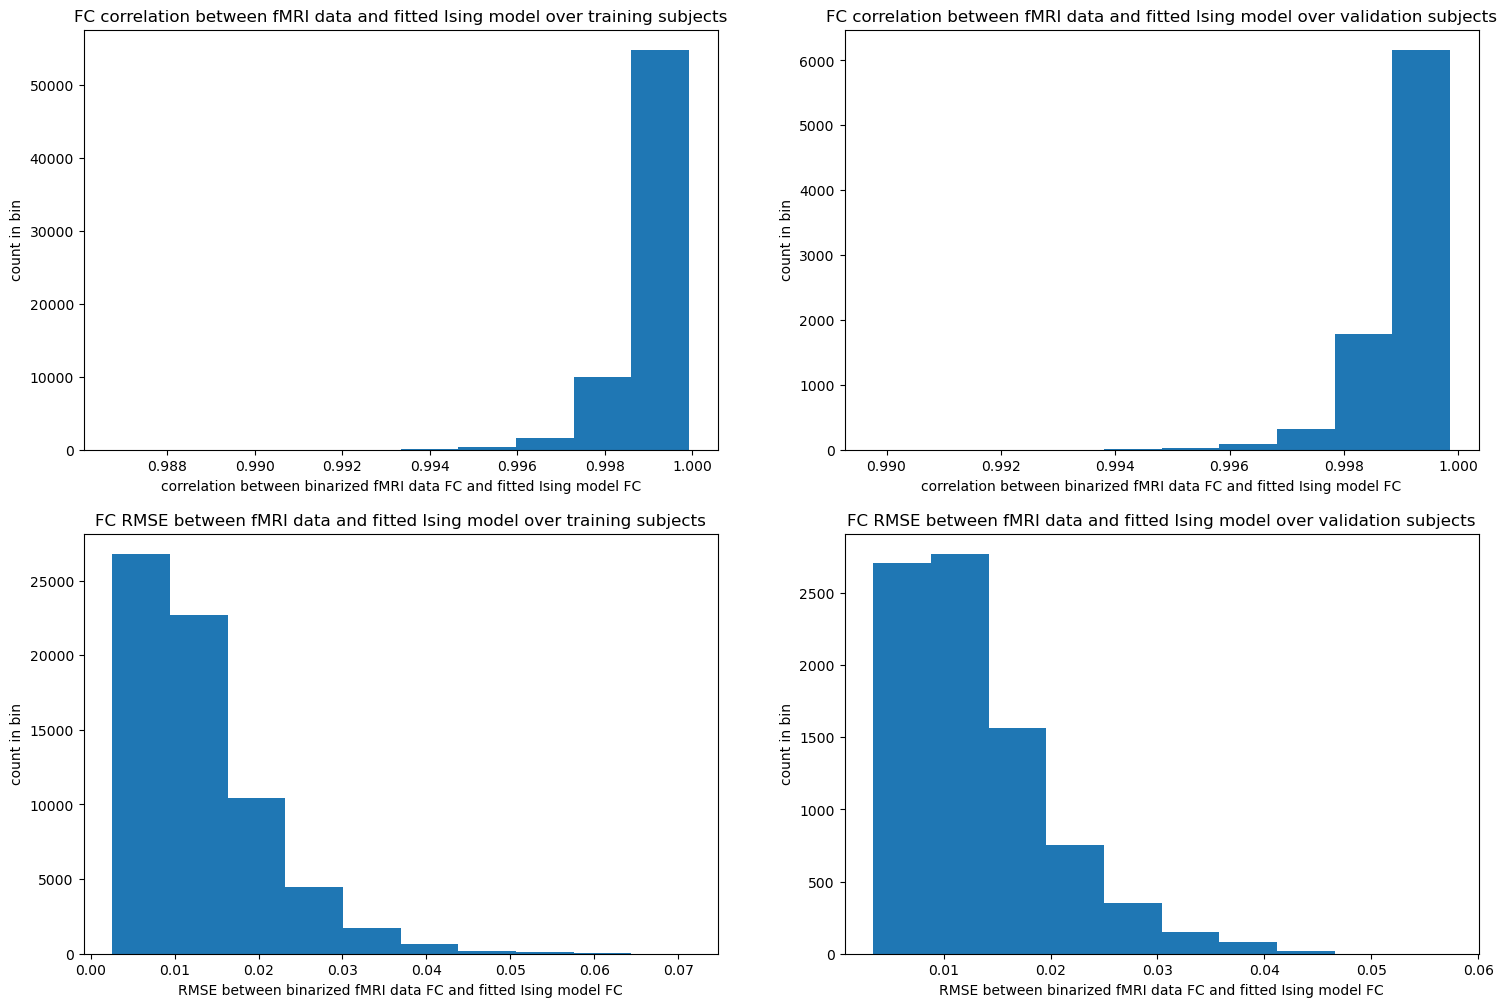

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[0,0].hist( training_corr.flatten().detach().cpu().numpy() )
axs[0,0].set_xlabel('correlation between binarized fMRI data FC and fitted Ising model FC')
axs[0,0].set_ylabel('count in bin')
axs[0,0].set_title('FC correlation between fMRI data and fitted Ising model over training subjects')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[0,1].hist( validation_corr.flatten().detach().cpu().numpy() )
axs[0,1].set_xlabel('correlation between binarized fMRI data FC and fitted Ising model FC')
axs[0,1].set_ylabel('count in bin')
axs[0,1].set_title('FC correlation between fMRI data and fitted Ising model over validation subjects')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[1,0].hist( training_rmse.flatten().detach().cpu().numpy() )
axs[1,0].set_xlabel('RMSE between binarized fMRI data FC and fitted Ising model FC')
axs[1,0].set_ylabel('count in bin')
axs[1,0].set_title('FC RMSE between fMRI data and fitted Ising model over training subjects')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[1,1].hist( validation_rmse.flatten().detach().cpu().numpy() )
axs[1,1].set_xlabel('RMSE between binarized fMRI data FC and fitted Ising model FC')
axs[1,1].set_ylabel('count in bin')
axs[1,1].set_title('FC RMSE between fMRI data and fitted Ising model over validation subjects')
plt.show()

In [122]:
# num_nodes = 21
# window_length = 50
# scaled_learning_rate = 0.001/window_length
# threshold = 0.1
# beta = 0.5
# ising_model_param_string = f'nodes_{num_nodes}_window_{window_length}_lr_{scaled_learning_rate:.3f}_threshold_{threshold:.3f}_beta_{beta:.3f}'
group_data_subset = 'training'
epoch_group = 4
group_file_suffix = f'{ising_model_param_string}_group_{group_data_subset}_epoch_{epoch_group}'
group_corr_file_name = os.path.join(stats_dir, f'corr_{group_file_suffix}.pt')
group_corr = torch.load(group_corr_file_name)
print(f'loaded {group_corr_file_name}')
print( 'group_corr size', group_corr.size() )
group_rmse_file_name = os.path.join(stats_dir, f'rmse_{group_file_suffix}.pt')
group_rmse = torch.load(group_rmse_file_name)
print(f'loaded {group_rmse_file_name}')
print( 'group_rmse size', group_rmse.size() )

loaded E:\Ising_model_results_daai\corr_nodes_21_window_50_lr_0.000_threshold_0.100_beta_0.500_group_training_epoch_4.pt
group_corr size torch.Size([1000])
loaded E:\Ising_model_results_daai\rmse_nodes_21_window_50_lr_0.000_threshold_0.100_beta_0.500_group_training_epoch_4.pt
group_rmse size torch.Size([1000])


In [125]:
print_stats(name='training subject group Ising model-fMRI FC correlation', values=group_corr)
print_stats(name='training subject group Ising model-fMRI FC RMSE', values=group_rmse)

The distribution of training subject group Ising model-fMRI FC correlation values has median 0.981 with 95% CI [0.975, 0.986] and range [0.971, 0.988].
The distribution of training subject group Ising model-fMRI FC RMSE values has median 0.0442 with 95% CI [0.0349, 0.0541] and range [0.029, 0.0614].


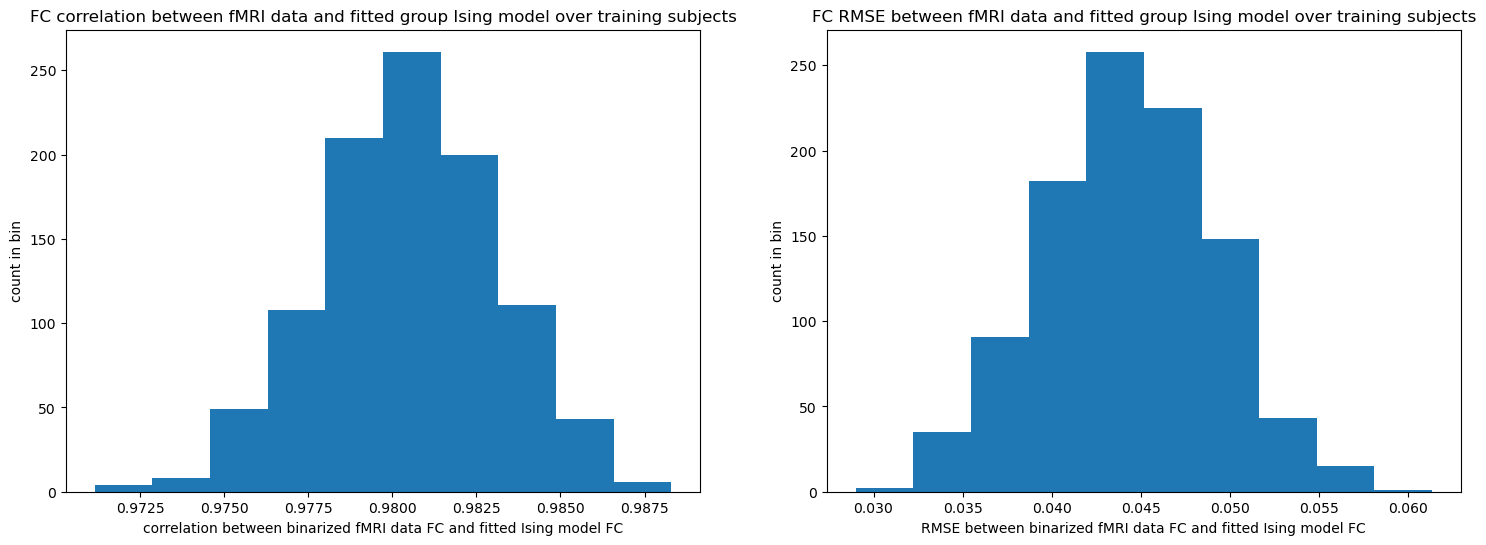

In [124]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[0].hist( group_corr.flatten().detach().cpu().numpy() )
axs[0].set_xlabel('correlation between binarized fMRI data FC and fitted Ising model FC')
axs[0].set_ylabel('count in bin')
axs[0].set_title('FC correlation between fMRI data and fitted group Ising model over training subjects')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[1].hist( group_rmse.flatten().detach().cpu().numpy() )
axs[1].set_xlabel('RMSE between binarized fMRI data FC and fitted Ising model FC')
axs[1].set_ylabel('count in bin')
axs[1].set_title('FC RMSE between fMRI data and fitted group Ising model over training subjects')
plt.show()

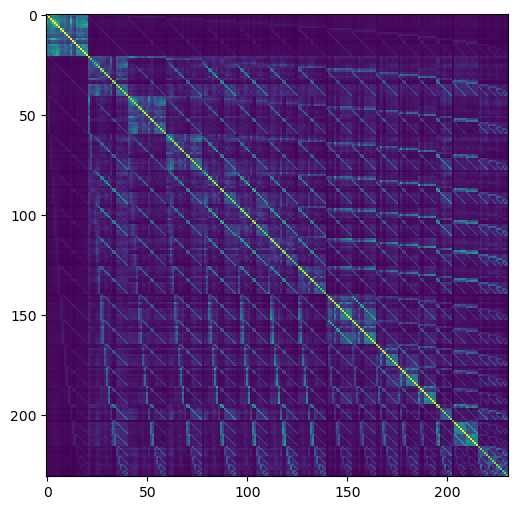

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_ising.abs().detach().cpu().numpy() )

In [513]:
num_reps_group = 1000
epoch_group = 4
fim_param_string = f'{ising_model_param_string}_reps_{num_reps_group}_epoch_{epoch_group}'
fim_ising_file_name = os.path.join(stats_dir, f'fim_ising_{fim_param_string}.pt')
fim_ising = torch.load(fim_ising_file_name)
print( 'fim_ising size', fim_ising.size() )
L_ising_file_name = os.path.join(stats_dir, f'L_ising_{fim_param_string}.pt')
L_ising = torch.load(L_ising_file_name)
print( 'L_ising size', L_ising.size() )
V_ising_file_name = os.path.join(stats_dir, f'V_ising_{fim_param_string}.pt')
V_ising = torch.load(V_ising_file_name)
print( 'V_ising size', V_ising.size() )
offsets_indi_training_file_name = os.path.join(stats_dir, f'offsets_indi_training_ising_{fim_param_string}.pt')
offsets_indi_training = torch.load(offsets_indi_training_file_name)
print( 'offsets_indi_training size', offsets_indi_training.size() )
offsets_indi_validation_file_name = os.path.join(stats_dir, f'offsets_indi_validation_ising_{fim_param_string}.pt')
offsets_indi_validation = torch.load(offsets_indi_validation_file_name)
print( 'offsets_indi_validation size', offsets_indi_validation.size() )
projections_group_ising_file_name = os.path.join(stats_dir, f'projections_group_ising_{fim_param_string}.pt')
projections_group_ising = torch.load(projections_group_ising_file_name)
print( 'projections_group_ising size', projections_group_ising.size() )

fim_ising size torch.Size([231, 231])
L_ising size torch.Size([231])
V_ising size torch.Size([231, 231])
offsets_indi_training size torch.Size([669, 100, 231])
offsets_indi_validation size torch.Size([84, 100, 231])
projections_group_ising size torch.Size([1000, 231])


In [514]:
intra_subject_var_training = offsets_indi_training.var(dim=1)
inter_subject_var_training = offsets_indi_training.var(dim=0)
intra_subject_var_validation = offsets_indi_validation.var(dim=1)
inter_subject_var_validation = offsets_indi_validation.var(dim=0)
projections_group_ising_var = projections_group_ising.var(dim=0)

In [515]:
log_L_ising = torch.log10(L_ising.real)
log_intra_subject_var_training = torch.log10( intra_subject_var_training.mean(dim=0) )
log_inter_subject_var_training = torch.log10( inter_subject_var_training.mean(dim=0) )
log_intra_subject_var_validation = torch.log10( intra_subject_var_validation.mean(dim=0) )
log_inter_subject_var_validation = torch.log10( inter_subject_var_validation.mean(dim=0) )
log_projections_group_ising_var = torch.log10( projections_group_ising_var )

In [516]:
L_intra_subject_var_training_corr = torch.corrcoef(  torch.stack( (log_L_ising, log_intra_subject_var_training), dim=0 )  )[0,1].item()
print(f'correlation between eigenvalue and training data intra-subject fitting variance along eigenvector in log-log scale: {L_intra_subject_var_training_corr:.3g}')
L_intra_subject_var_validation_corr = torch.corrcoef(  torch.stack( (log_L_ising, log_intra_subject_var_validation), dim=0 )  )[0,1].item()
print(f'correlation between eigenvalue and validation data intra-subject fitting variance along eigenvector in log-log scale: {L_intra_subject_var_validation_corr:.3g}')
L_inter_subject_var_training_corr = torch.corrcoef(  torch.stack( (log_L_ising, log_inter_subject_var_training), dim=0 )  )[0,1].item()
print(f'correlation between eigenvalue and training data inter-subject fitting variance along eigenvector in log-log scale: {L_inter_subject_var_training_corr:.3g}')
L_inter_subject_var_validation_corr = torch.corrcoef(  torch.stack( (log_L_ising, log_inter_subject_var_validation), dim=0 )  )[0,1].item()
print(f'correlation between eigenvalue and validation data inter-subject fitting variance along eigenvector in log-log scale: {L_inter_subject_var_validation_corr:.3g}')
L_group_var_corr = torch.corrcoef(  torch.stack( (log_L_ising, log_projections_group_ising_var), dim=0 )  )[0,1].item()
print(f'correlation between eigenvalue and group model fitting variance along eigenvector in log-log scale: {L_group_var_corr:.3g}')

correlation between eigenvalue and training data intra-subject fitting variance along eigenvector in log-log scale: -0.336
correlation between eigenvalue and validation data intra-subject fitting variance along eigenvector in log-log scale: -0.262
correlation between eigenvalue and training data inter-subject fitting variance along eigenvector in log-log scale: -0.805
correlation between eigenvalue and validation data inter-subject fitting variance along eigenvector in log-log scale: -0.761
correlation between eigenvalue and group model fitting variance along eigenvector in log-log scale: -0.18


(669, 231)
torch.Size([669, 231])


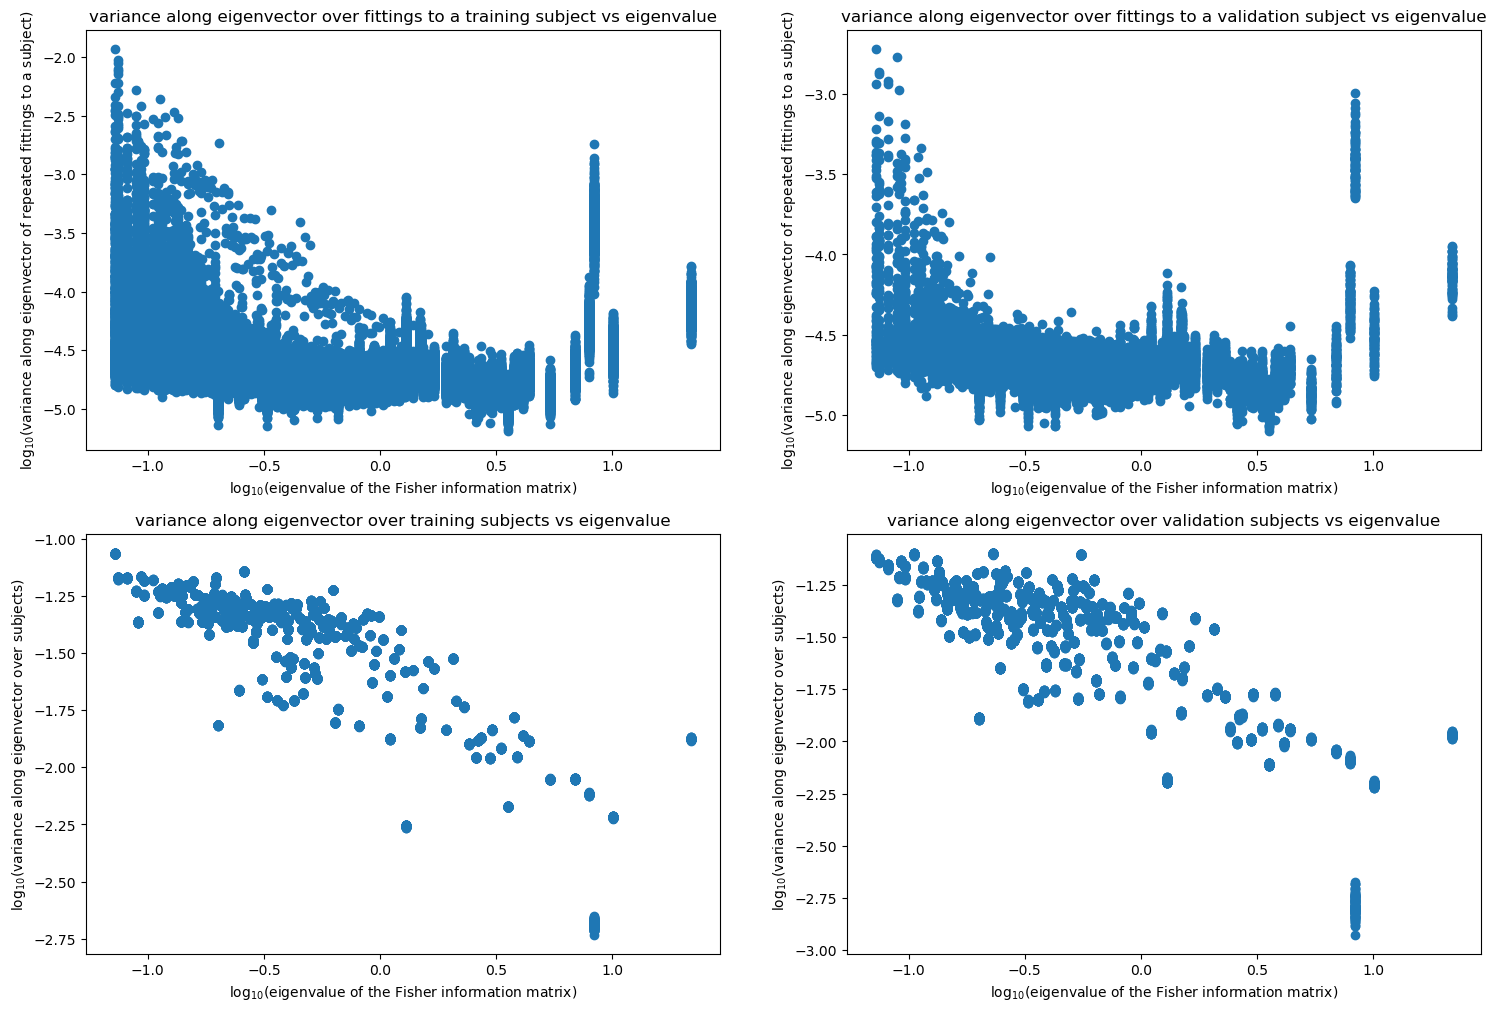

In [55]:
num_reps_indi = 100
log_L_ising_np_intra_training = log_L_ising[None,:].repeat( (num_training_subjects,1) ).detach().cpu().numpy()
log_L_ising_np_intra_validation = log_L_ising[None,:].repeat( (num_validation_subjects,1) ).detach().cpu().numpy()
log_L_ising_np_inter = log_L_ising[None,:].repeat( (num_reps_indi,1) ).detach().cpu().numpy()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
print( log_L_ising_np_intra_training.shape )
print( intra_subject_var_training.size() )
axs[0,0].scatter( log_L_ising_np_intra_training, torch.log10(intra_subject_var_training).detach().cpu().numpy() )
axs[0,0].set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs[0,0].set_ylabel('log$_{10}$(variance along eigenvector of repeated fittings to a subject)')
axs[0,0].set_title('variance along eigenvector over fittings to a training subject vs eigenvalue')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[0,1].scatter( log_L_ising_np_intra_validation, torch.log10(intra_subject_var_validation).detach().cpu().numpy() )
axs[0,1].set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs[0,1].set_ylabel('log$_{10}$(variance along eigenvector of repeated fittings to a subject)')
axs[0,1].set_title('variance along eigenvector over fittings to a validation subject vs eigenvalue')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[1,0].scatter( log_L_ising_np_inter, torch.log10(inter_subject_var_training).detach().cpu().numpy() )
axs[1,0].set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs[1,0].set_ylabel('log$_{10}$(variance along eigenvector over subjects)')
axs[1,0].set_title('variance along eigenvector over training subjects vs eigenvalue')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[1,1].scatter( log_L_ising_np_inter, torch.log10(inter_subject_var_validation).detach().cpu().numpy() )
axs[1,1].set_xlabel('log$_{10}$(eigenvalue of the Fisher information matrix)')
axs[1,1].set_ylabel('log$_{10}$(variance along eigenvector over subjects)')
axs[1,1].set_title('variance along eigenvector over validation subjects vs eigenvalue')
plt.show()

In [414]:
# box plot version
def plot_variance_vs_eigenvalue(name:str, variances:torch.Tensor, row:int):
    sorted_L, L_indices = torch.sort(log_L_ising)
    log_L_ising_list = sorted_L.tolist()
    log_L_ising_pos = log_L_ising_list
    log_L_ising_labels = [f'{logL:.3g}' for logL in log_L_ising_list]
    sorted_log_variances = torch.log10(variances).flatten(start_dim=0, end_dim=-2)[:,L_indices]
    log_variances_np = sorted_log_variances.detach().cpu().numpy()
    axs[row].boxplot(log_variances_np, labels=log_L_ising_labels)
    axs[row].set_xticklabels( axs[row].get_xticklabels(), rotation=90, ha='right' )
    axs[row].set_xlabel('log$_{10}$(|eigenvalue|)')
    axs[row].set_ylabel('log$_{10}$' + f'({name})')
    axs[row].set_title(f'{name} vs eigenvalue')

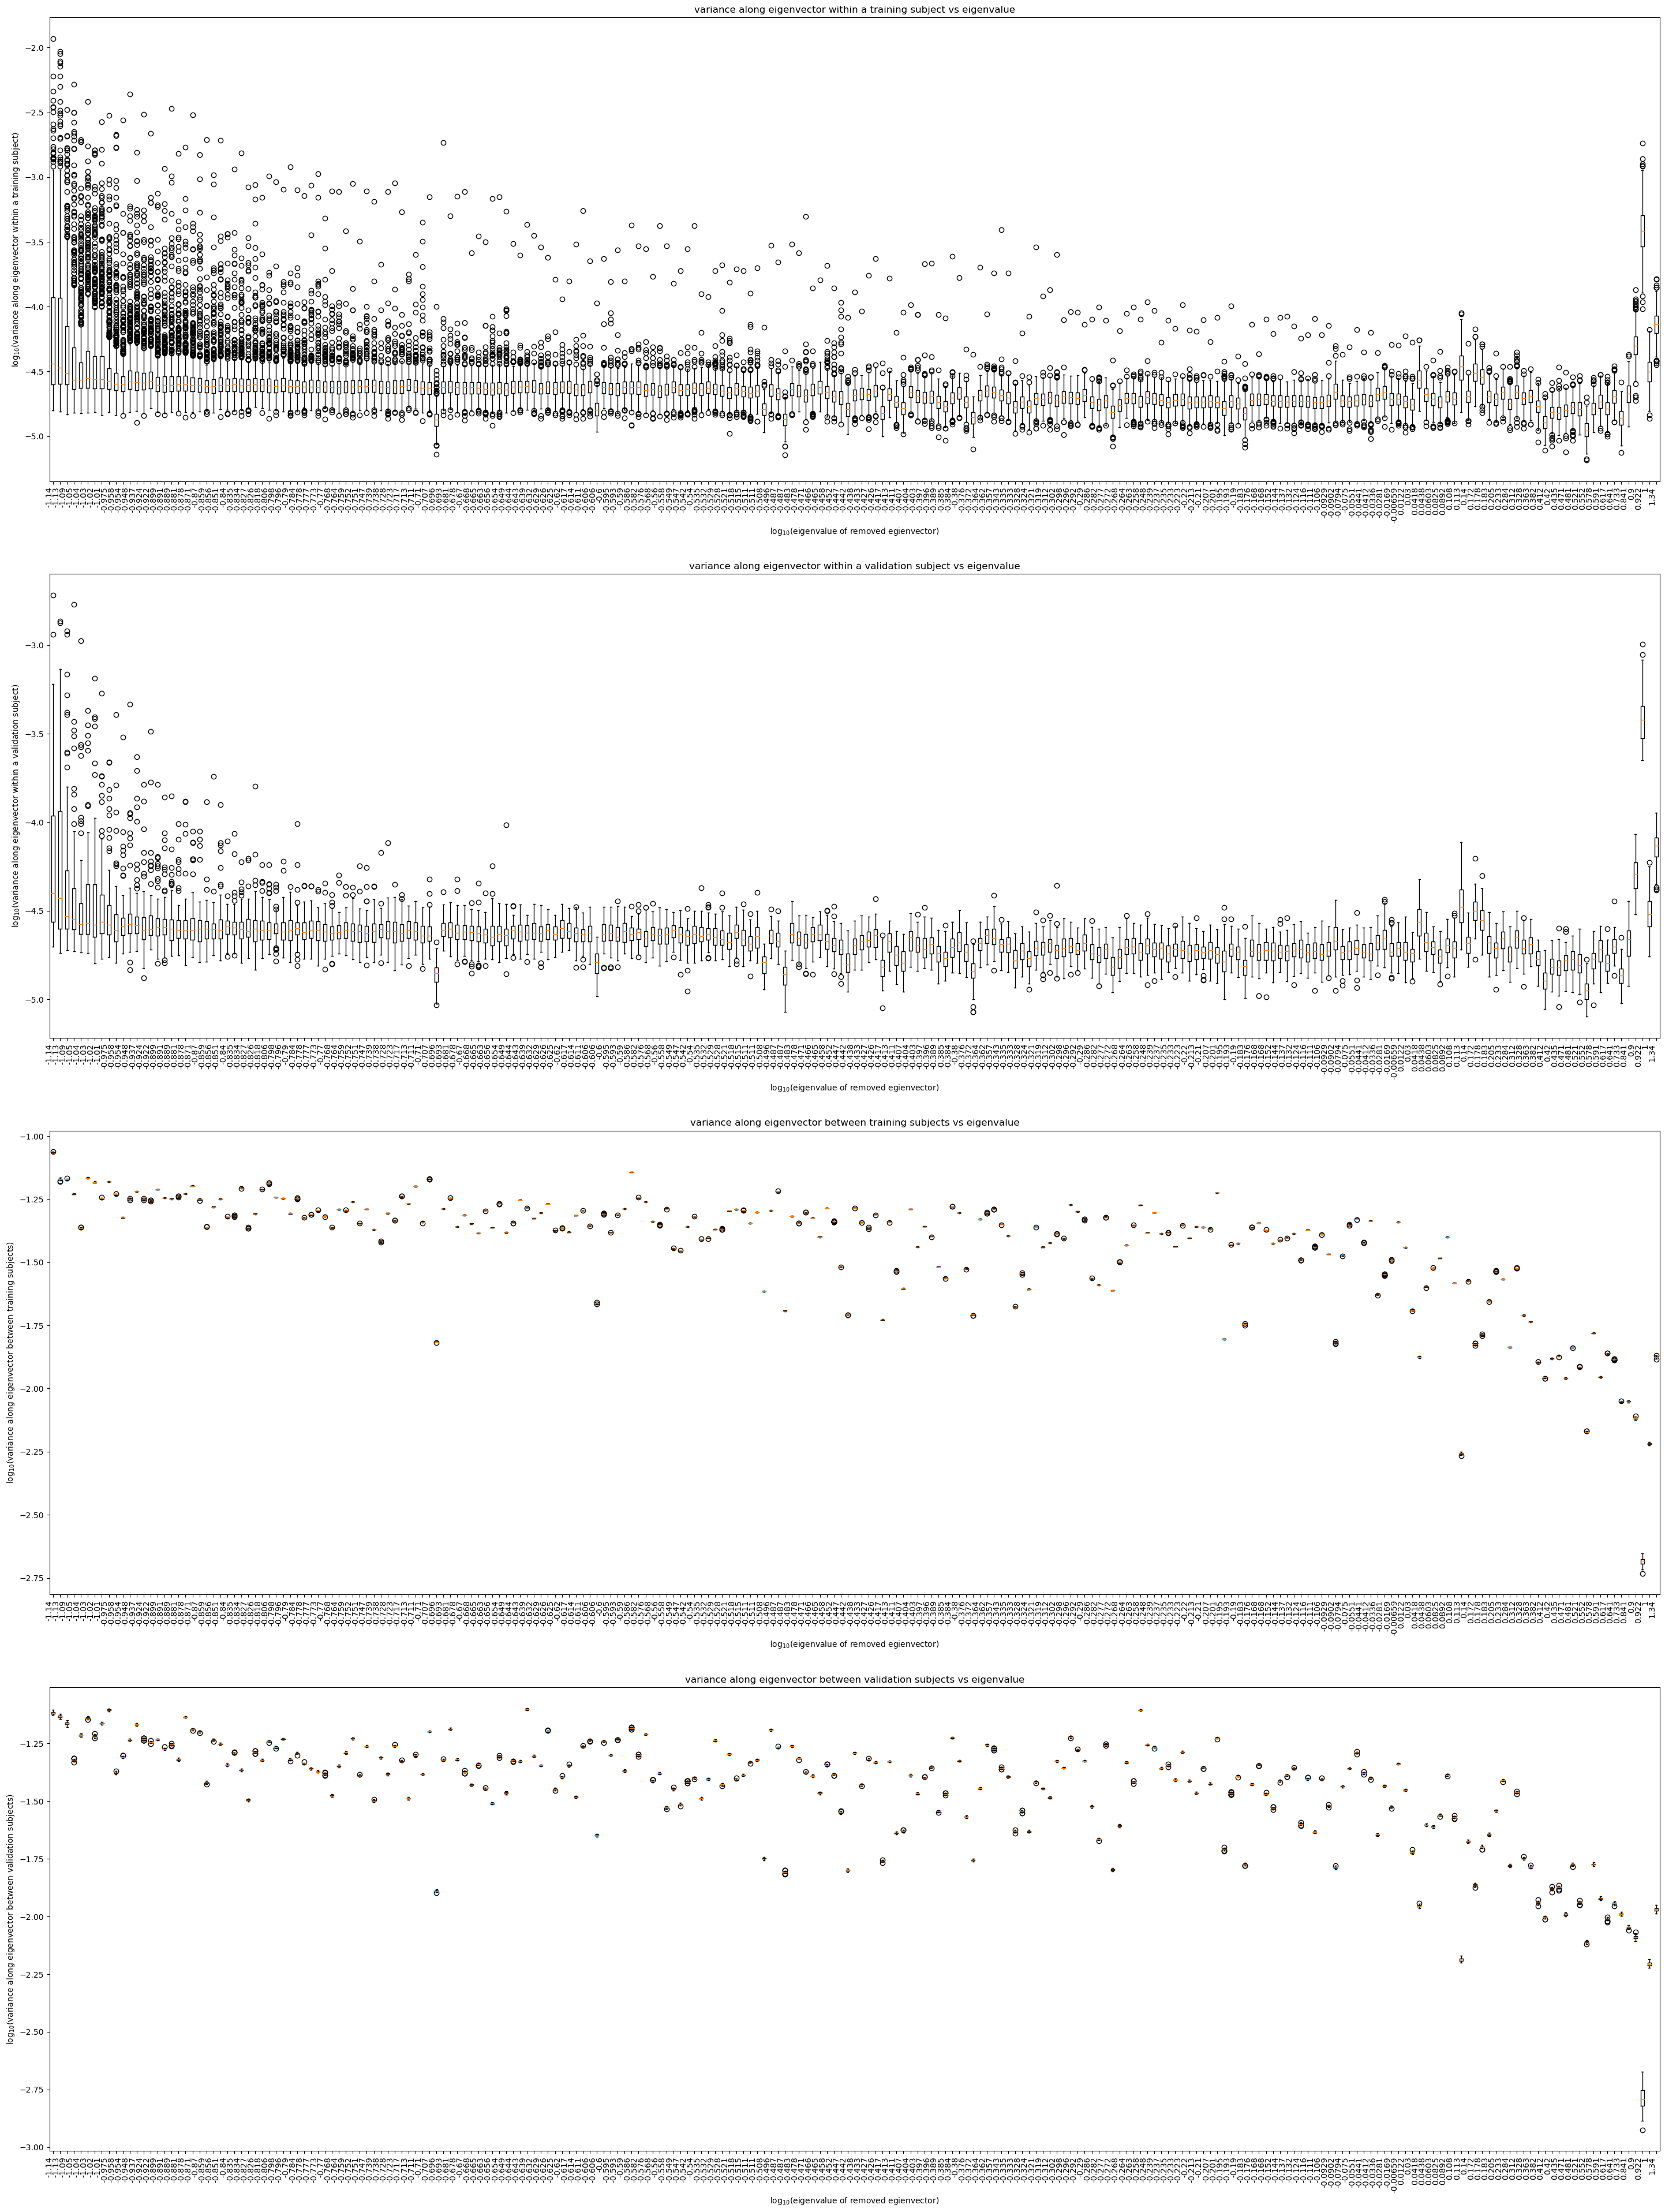

In [415]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(36, 48))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
plot_variance_vs_eigenvalue(name='variance along eigenvector within a training subject', variances=intra_subject_var_training, row=0)
plot_variance_vs_eigenvalue(name='variance along eigenvector within a validation subject', variances=intra_subject_var_validation, row=1)
plot_variance_vs_eigenvalue(name='variance along eigenvector between training subjects', variances=inter_subject_var_training, row=2)
plot_variance_vs_eigenvalue(name='variance along eigenvector between validation subjects', variances=inter_subject_var_validation, row=3)
plt.show()

In [435]:
# error bar plot version without log of variances
def plot_variance_vs_eigenvalue(name:str, variances:torch.Tensor, row:int, col:int):
    variances_quantiles = torch.quantile( input=variances.flatten(start_dim=0, end_dim=-2), q=torch.tensor([0.025, 0.5, 0.975], device=variances.device), dim=0 )
    variances_median = variances_quantiles[1,:]
    variances_below = variances_median - variances_quantiles[0,:]
    variances_above = variances_quantiles[2,:] - variances_median
    variances_err = torch.stack( (variances_below, variances_above), dim=0 )
    axs[row,col].errorbar( x=log_L_ising.detach().cpu().numpy(), y=variances_median.detach().cpu().numpy(), yerr=variances_err.detach().cpu().numpy(), linestyle='', marker='o', markeredgecolor='r' )
    axs[row,col].set_xlabel('log$_{10}$(|eigenvalue|)')
    axs[row,col].set_ylabel('median and 95% CI of variance')
    axs[row,col].set_title(f'{name} vs eigenvalue')

In [438]:
# error bar plot version with log of variance
def plot_variance_vs_eigenvalue(name:str, variances:torch.Tensor, row:int, col:int):
    variances_quantiles = torch.quantile( input=variances.log10().flatten(start_dim=0, end_dim=-2), q=torch.tensor([0.025, 0.5, 0.975], device=variances.device), dim=0 )
    variances_median = variances_quantiles[1,:]
    variances_below = variances_median - variances_quantiles[0,:]
    variances_above = variances_quantiles[2,:] - variances_median
    variances_err = torch.stack( (variances_below, variances_above), dim=0 )
    axs[row,col].errorbar( x=log_L_ising.detach().cpu().numpy(), y=variances_median.detach().cpu().numpy(), yerr=variances_err.detach().cpu().numpy(), linestyle='', marker='o', markeredgecolor='r' )
    axs[row,col].set_xlabel('log$_{10}$(|eigenvalue|)')
    axs[row,col].set_ylabel('median and 95% CI of log$_{10}$(variance)')
    axs[row,col].set_title(f'{name} vs eigenvalue')

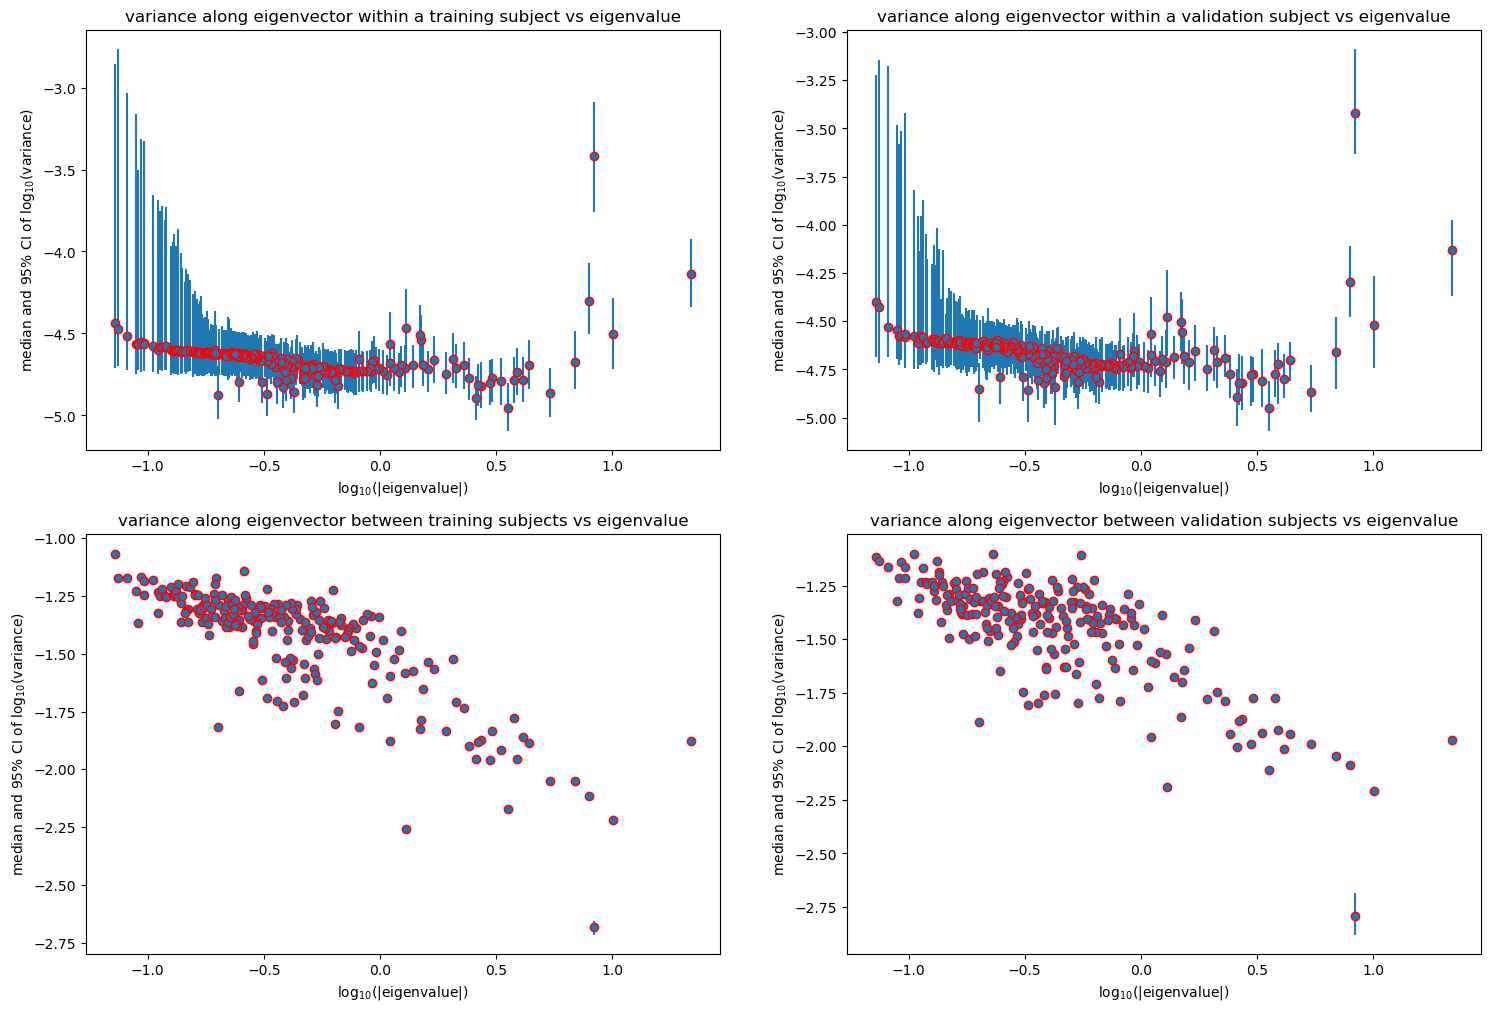

In [517]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
plot_variance_vs_eigenvalue(name='variance along eigenvector within a training subject', variances=intra_subject_var_training, row=0, col=0)
plot_variance_vs_eigenvalue(name='variance along eigenvector within a validation subject', variances=intra_subject_var_validation, row=0, col=1)
plot_variance_vs_eigenvalue(name='variance along eigenvector between training subjects', variances=inter_subject_var_training, row=1, col=0)
plot_variance_vs_eigenvalue(name='variance along eigenvector between validation subjects', variances=inter_subject_var_validation, row=1, col=1)
plt.show()

In [524]:
# error bar plot version with log of variance
def plot_variance_vs_eigenvalue_oneplot(name:str, variances:torch.Tensor):
    axs.plot( log_L_ising.detach().cpu().numpy(), variances.detach().cpu().numpy(), linestyle='', marker='o', markeredgecolor='r' )
    axs.set_xlabel('log$_{10}$(|eigenvalue|)')
    axs.set_ylabel('log$_{10}$(variance)')
    axs.set_title(f'{name} vs eigenvalue')

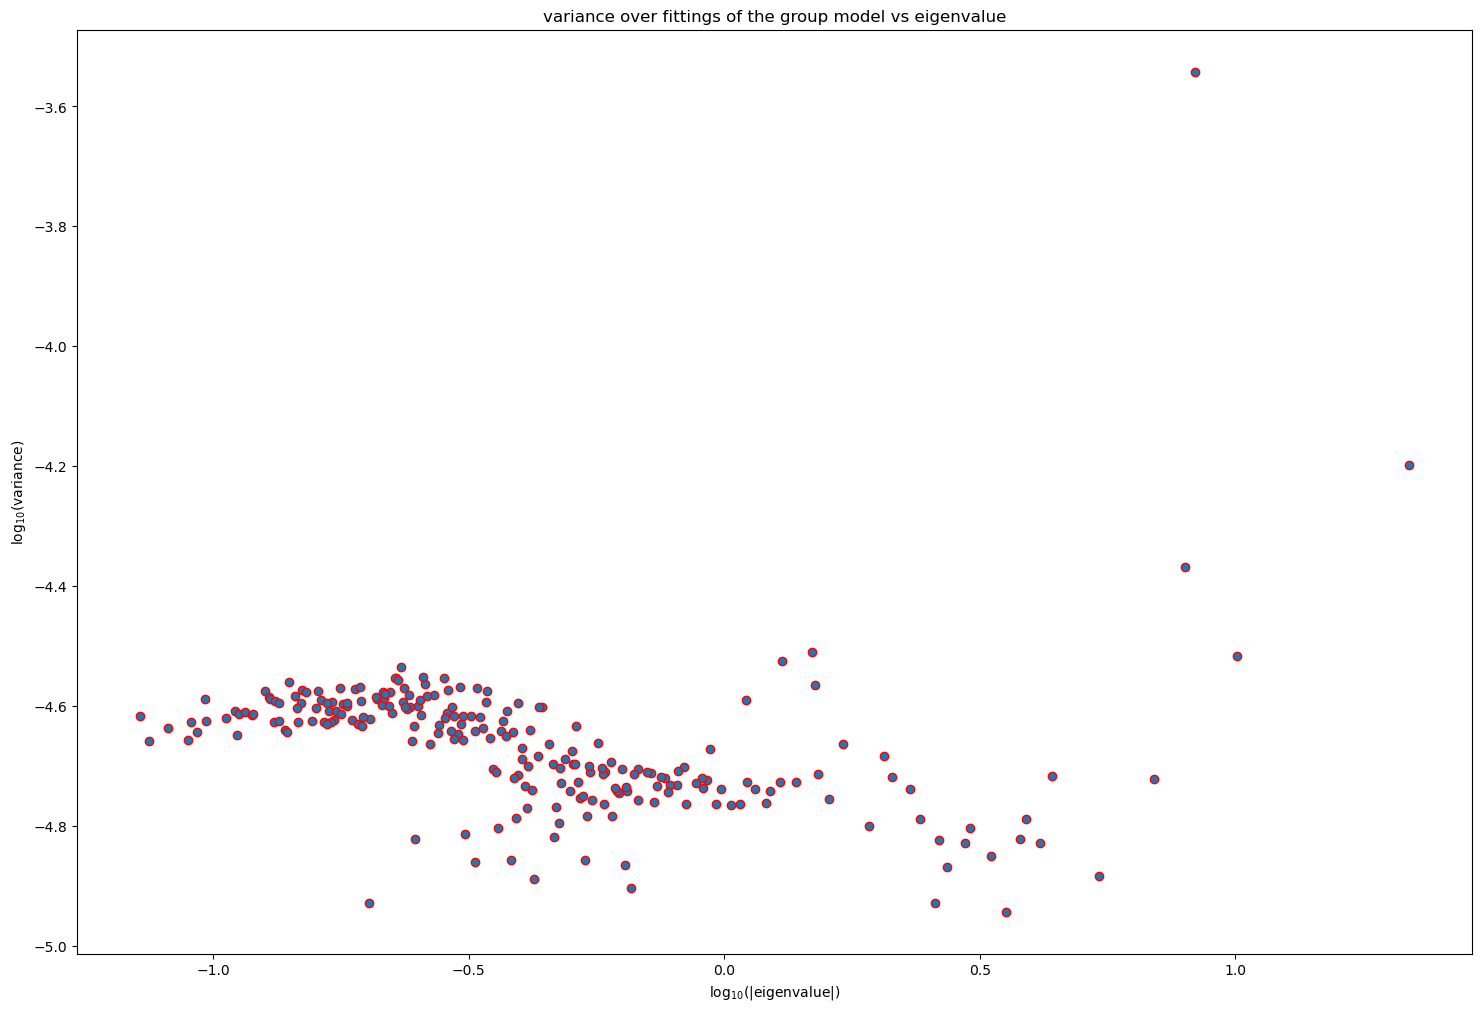

In [525]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 12))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
plot_variance_vs_eigenvalue_oneplot(name='variance over fittings of the group model', variances=log_projections_group_ising_var)
plt.show()

In [59]:
# creates a num_rows*num_cols 1-D Tensor of booleans where each value is True if and only if it is part of the upper triangle of a flattened num_rows x num_cols matrix.
# If we want the upper triangular part of a Tensor with one or more batch dimensions, we can flatten the last two dimensions together, and then use this.
def get_triu_logical_index(num_rows:int, num_cols:int):
    return ( torch.arange(start=0, end=num_rows, dtype=torch.int, device=device)[:,None] < torch.arange(start=0, end=num_cols, dtype=torch.int, device=device)[None,:] ).flatten()

def get_h_and_J(params:torch.Tensor, num_nodes:int=num_nodes):
    num_params = params.size(dim=-1)
    h = torch.index_select( input=params, dim=-1, index=torch.arange(end=num_nodes, device=params.device) )
    J_flat_ut = torch.index_select( input=params, dim=-1, index=torch.arange(start=num_nodes, end=num_params, device=params.device) )
    ut_indices = get_triu_logical_index(num_rows=num_nodes, num_cols=num_nodes).nonzero().flatten()
    J_flat = torch.zeros( (num_nodes * num_nodes,), dtype=params.dtype, device=params.device )
    J_flat.index_copy_(dim=-1, index=ut_indices, source=J_flat_ut)
    J = J_flat.unflatten( dim=-1, sizes=(num_nodes, num_nodes) )
    J_sym = J + J.transpose(dim0=-2, dim1=-1)
    return h, J_sym

In [97]:
def show_ising_model_param_map(name:str, params:torch.Tensor):
    h, J = get_h_and_J(params=params, num_nodes=num_nodes)
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18, 16), gridspec_kw={'width_ratios':[1], 'height_ratios':[1,30], 'hspace':0.2})
    axs[0].imshow( h.unsqueeze(dim=0).detach().cpu().numpy() )
    axs[0].set_xticks( range(num_nodes), labels=selected_node_names, rotation=45, fontsize=10 )
    axs[0].set_yticks( [], labels=[], rotation=0, fontsize=0 )
    axs[0].set_title(f'{name} for bias (h) parameters')
    cmap_pos = axs[1].imshow( J.detach().cpu().numpy() )
    axs[1].set_xticks( range(num_nodes), labels=selected_node_names, rotation=45, fontsize=10 )
    axs[1].set_yticks( range(num_nodes), labels=selected_node_names, rotation=45, fontsize=10 )
    axs[1].set_title(f'{name} for coupling (J) parameters')
    fig.colorbar(cmap_pos, location = 'bottom', shrink = 0.5)

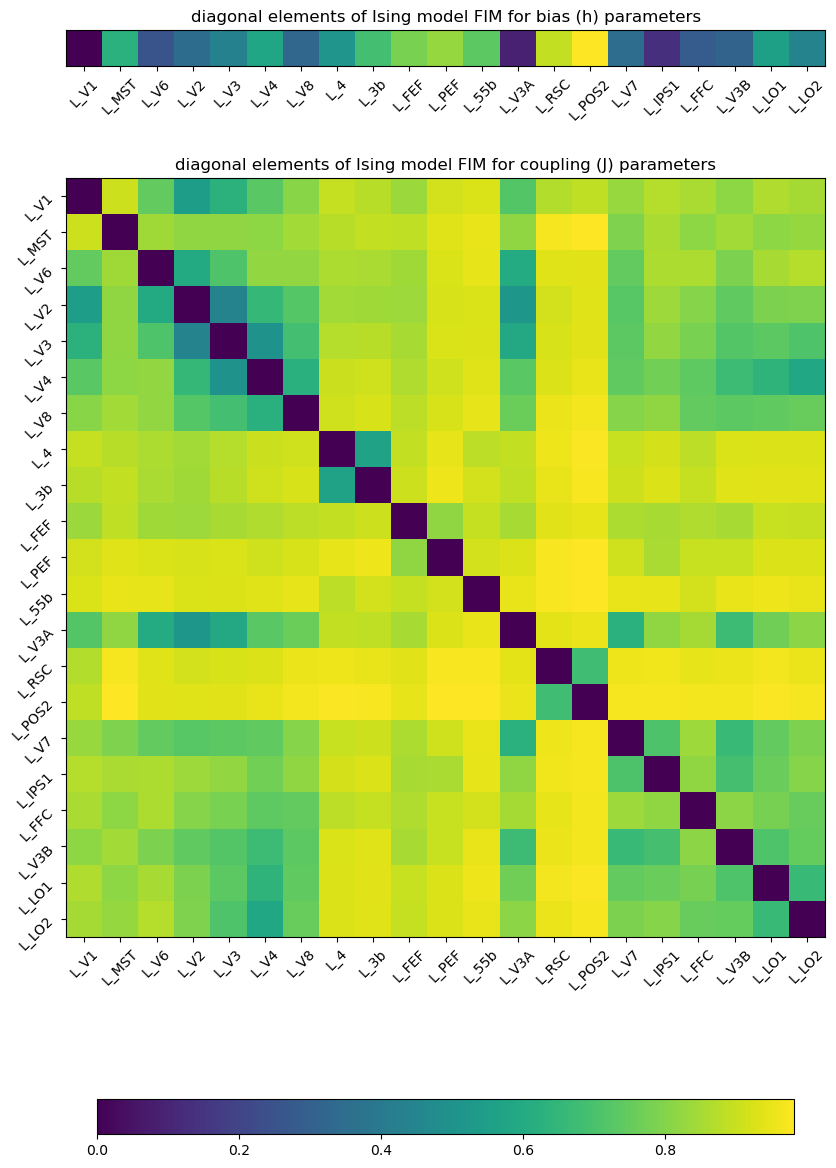

In [98]:
fim_ising_diag = torch.diag(fim_ising).abs()
fim_diag_name = 'diagonal elements of Ising model FIM'
show_ising_model_param_map(name=fim_diag_name, params=fim_ising_diag)

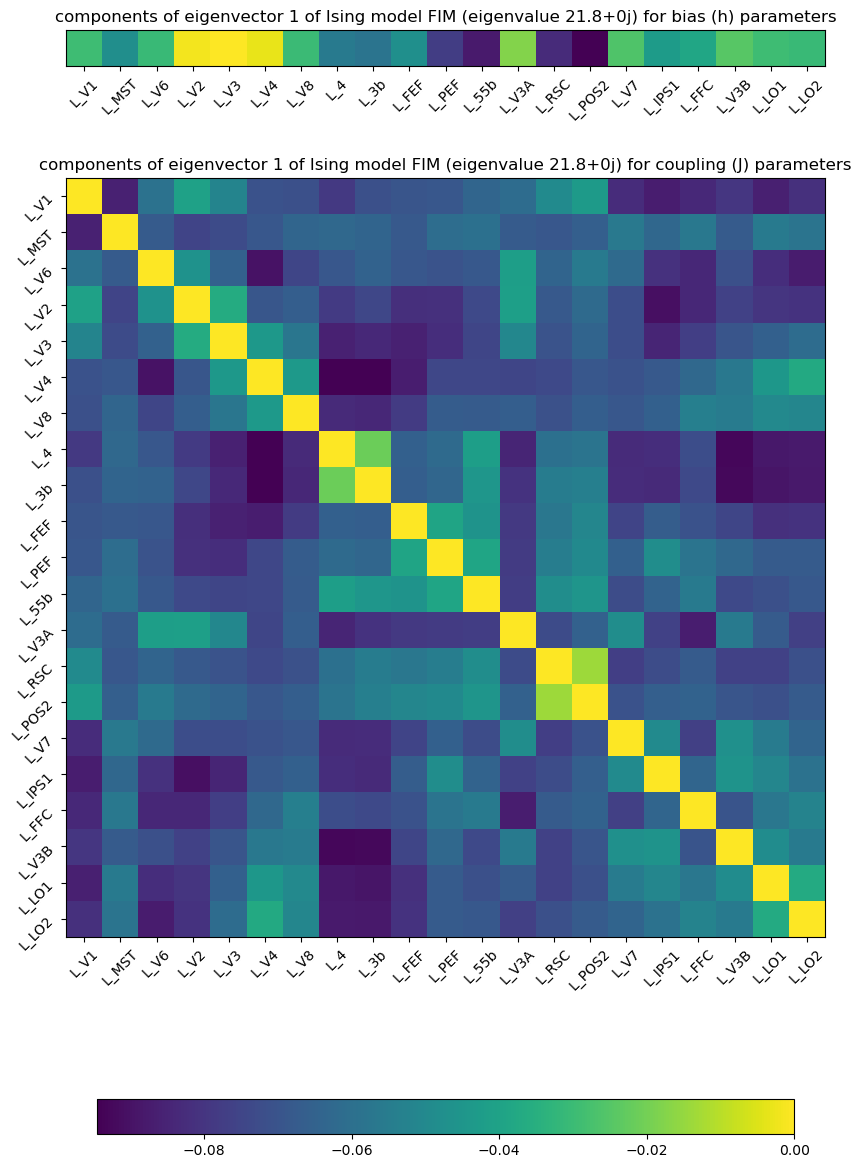

In [260]:
fim_ising_diag = torch.diag(fim_ising)
fim_diag_name = 'diagonal elements of Ising model FIM'
eig_index = 0
show_ising_model_param_map(name=f'components of eigenvector {eig_index+1} of Ising model FIM (eigenvalue {L_ising[eig_index]:.3g})', params=V_ising[:,eig_index].real)

In [261]:
num_sim_steps = 48000
group_vs_indi_string = f'group_ising_vs_individual_fmri_{fim_param_string}_steps_{num_sim_steps}'
corr_group_vs_individual_training = torch.load( os.path.join(stats_dir, f'fc_corr_{group_vs_indi_string}_training.pt') )
print( 'corr_group_vs_individual_training size', corr_group_vs_individual_training.size() )
corr_group_vs_individual_validation = torch.load( os.path.join(stats_dir, f'fc_corr_{group_vs_indi_string}_validation.pt') )
print( 'corr_group_vs_individual_validation size', corr_group_vs_individual_validation.size() )
rmse_group_vs_individual_training = torch.load( os.path.join(stats_dir, f'fc_rmse_{group_vs_indi_string}_training.pt') )
print( 'rmse_group_vs_individual_training size', rmse_group_vs_individual_training.size() )
rmse_group_vs_individual_validation = torch.load( os.path.join(stats_dir, f'fc_rmse_{group_vs_indi_string}_validation.pt') )
print( 'rmse_group_vs_individual_validation size', rmse_group_vs_individual_validation.size() )

corr_group_vs_individual_training size torch.Size([669])
corr_group_vs_individual_validation size torch.Size([84])
rmse_group_vs_individual_training size torch.Size([669])
rmse_group_vs_individual_validation size torch.Size([84])


In [362]:
num_sim_steps = 48000
minus_offset_string = f'minus_offset_{fim_param_string}_steps_{num_sim_steps}'
corr_minus_offset_training = torch.load( os.path.join(stats_dir, f'fc_corr_{minus_offset_string}_training.pt') )
print( 'corr_minus_offset_training size', corr_minus_offset_training.size() )
corr_minus_offset_validation = torch.load( os.path.join(stats_dir, f'fc_corr_{minus_offset_string}_validation.pt') )
print( 'corr_minus_offset_validation size', corr_minus_offset_validation.size() )
rmse_minus_offset_training = torch.load( os.path.join(stats_dir, f'fc_rmse_{minus_offset_string}_training.pt') )
print( 'rmse_minus_offset_training size', rmse_minus_offset_training.size() )
rmse_minus_offset_validation = torch.load( os.path.join(stats_dir, f'fc_rmse_{minus_offset_string}_validation.pt') )
print( 'rmse_minus_offset_validation size', rmse_minus_offset_validation.size() )

corr_minus_offset_training size torch.Size([669, 100, 232])
corr_minus_offset_validation size torch.Size([84, 100, 232])
rmse_minus_offset_training size torch.Size([669, 100, 232])
rmse_minus_offset_validation size torch.Size([84, 100, 232])


In [363]:
# scatter plot version
def plot_removal_effect(name:str, values_minus_offset:torch.Tensor, values_group:torch.Tensor, row:int, col:int, margin:float=0.05):
    values_full = values_minus_offset[:,:,-1]
    values_minus_offset = values_minus_offset[:,:,:-1]
    num_subjects, num_reps, _ = values_minus_offset.size()
    L_min = log_L_ising.min()
    L_max = log_L_ising.max()
    L_range = L_max - L_min
    full_pos = L_min - margin*L_range
    group_pos = L_max + margin*L_range
    log_L_ising_np = log_L_ising[None,None,:].repeat( (num_subjects,num_reps,1) ).detach().cpu().numpy()
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs[row,col].scatter( torch.full_like(input=values_full, fill_value=full_pos).detach().cpu().numpy(), values_full.detach().cpu().numpy(), label='fully individualized' )
    axs[row,col].scatter( log_L_ising_np, values_minus_offset.detach().cpu().numpy(), label='without one offset' )
    axs[row,col].scatter( torch.full_like(input=values_group, fill_value=group_pos).detach().cpu().numpy(), values_group.detach().cpu().numpy(), label='group' )
    axs[row,col].set_xlabel('log$_{10}$(eigenvalue of removed egienvector)')
    axs[row,col].set_ylabel(name)
    axs[row,col].set_title(f'effect of removing the offset along an eigenvector on {name}')
    axs[row,col].legend()

In [392]:
# box plot version
def plot_removal_effect(name:str, values_minus_offset:torch.Tensor, values_group:torch.Tensor, row:int, col:int, margin:float=0.05):
    num_subjects, num_reps, _ = values_minus_offset.size()
    L_min = log_L_ising.min()
    L_max = log_L_ising.max()
    L_range = L_max - L_min
    full_pos = L_min - margin*L_range
    group_pos = L_max + margin*L_range
    log_L_ising_list = log_L_ising.tolist()
    log_L_ising_pos = [full_pos.item()] + log_L_ising_list + [group_pos.item()]
    log_L_ising_labels = ['full'] + [f'{logL:.3g}' for logL in log_L_ising_list] + ['group']
    values_minus_offset_list_list = values_minus_offset.flatten(start_dim=0, end_dim=-2).transpose(dim0=-2, dim1=-1).tolist()
    values_group_list = values_group.flatten().tolist()
    all_values_list = [ values_minus_offset_list_list[-1] ] + values_minus_offset_list_list[:-1] + [ values_group_list ]
    axs[row,col].boxplot(all_values_list, positions=log_L_ising_pos, labels=log_L_ising_labels, widths=0.05)
    axs[row,col].set_xticklabels( axs[row,col].get_xticklabels(), rotation=90, ha='right' )
    axs[row,col].set_xlabel('log$_{10}$(eigenvalue of removed egienvector)')
    axs[row,col].set_ylabel(name)
    axs[row,col].set_title(f'effect of removing the offset along an eigenvector on {name}')

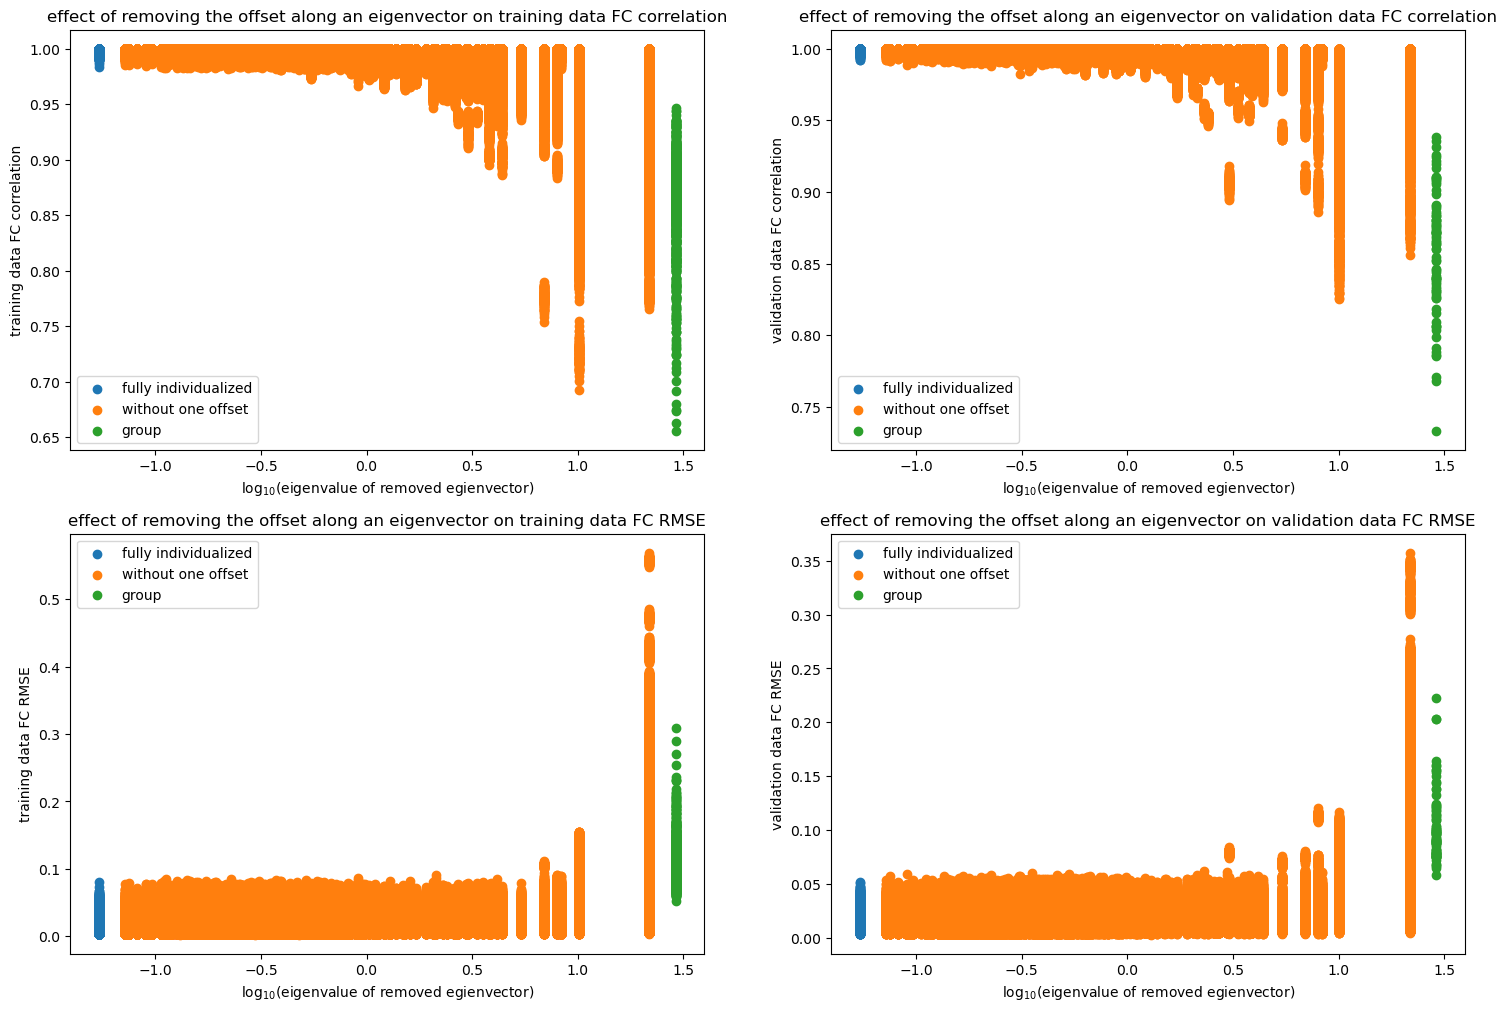

In [365]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 12) )
plot_removal_effect(name='training data FC correlation', values_minus_offset=corr_minus_offset_training, values_group=corr_group_vs_individual_training, row=0, col=0)
plot_removal_effect(name='validation data FC correlation', values_minus_offset=corr_minus_offset_validation, values_group=corr_group_vs_individual_validation, row=0, col=1)
plot_removal_effect(name='training data FC RMSE', values_minus_offset=rmse_minus_offset_training, values_group=rmse_group_vs_individual_training, row=1, col=0)
plot_removal_effect(name='validation data FC RMSE', values_minus_offset=rmse_minus_offset_validation, values_group=rmse_group_vs_individual_validation, row=1, col=1)
plt.show()

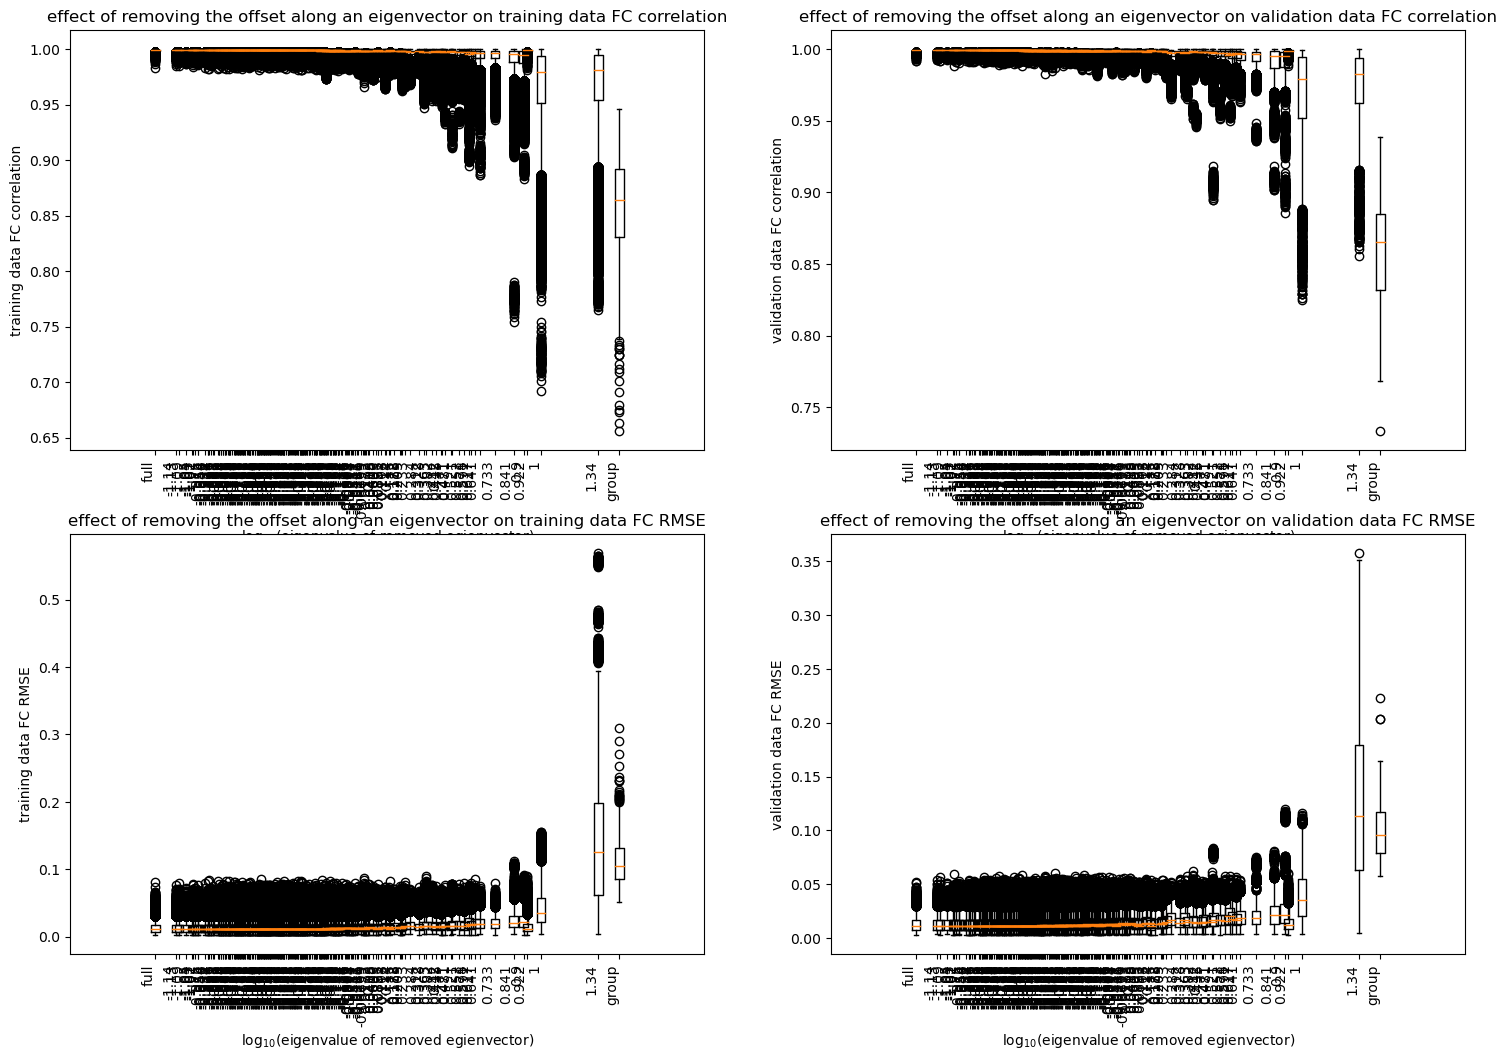

In [394]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 12) )
plot_removal_effect(name='training data FC correlation', values_minus_offset=corr_minus_offset_training, values_group=corr_group_vs_individual_training, row=0, col=0)
plot_removal_effect(name='validation data FC correlation', values_minus_offset=corr_minus_offset_validation, values_group=corr_group_vs_individual_validation, row=0, col=1)
plot_removal_effect(name='training data FC RMSE', values_minus_offset=rmse_minus_offset_training, values_group=rmse_group_vs_individual_training, row=1, col=0)
plot_removal_effect(name='validation data FC RMSE', values_minus_offset=rmse_minus_offset_validation, values_group=rmse_group_vs_individual_validation, row=1, col=1)
plt.show()

In [444]:
# error bar plot version
def plot_removal_effect(name:str, values_minus_offset:torch.Tensor, values_group:torch.Tensor, row:int, col:int, margin:float=0.05):
    q_95_and_median = torch.tensor([0.025, 0.5, 0.975], device=values_minus_offset.device)
    group_quantiles = torch.quantile( input=values_group.log10().flatten(), q=q_95_and_median )[:,None]
    vmo_quantiles = torch.quantile( input=values_minus_offset.log10().flatten(start_dim=0, end_dim=-2), q=q_95_and_median, dim=0 )
    full_quantiles = vmo_quantiles[:,-1]
    vmo_quantiles = vmo_quantiles[:,:-1]
    # vmo_quantiles = torch.cat( (vmo_quantiles[:,-1:], vmo_quantiles[:,:-1], group_quantiles), dim=-1  )
    vmo_median = vmo_quantiles[1,:]
    vmo_below = vmo_median - vmo_quantiles[0,:]
    vmo_above = vmo_quantiles[2,:] - vmo_median
    vmo_err = torch.stack( (vmo_below, vmo_above), dim=0 )
    # full
    full_median = full_quantiles[1].item()
    full_below = full_median - full_quantiles[0].item()
    full_above = full_quantiles[2].item() - full_median
    full_err = [ [full_below], [full_above] ]
    # group
    group_median = group_quantiles[1].item()
    group_below = group_median - group_quantiles[0].item()
    group_above = group_quantiles[2].item() - group_median
    group_err = [ [group_below], [group_above] ]
    # L_locations = [full_pos.item()] + log_L_ising.tolist() + [group_pos.item()]
    L_min = log_L_ising.min()
    L_max = log_L_ising.max()
    L_range = L_max - L_min
    full_pos = (L_min - margin*L_range).item()
    group_pos = (L_max + margin*L_range).item()
    L_locations = log_L_ising.tolist()
    axs[row,col].errorbar( x=L_locations, y=vmo_median.detach().cpu().numpy(), yerr=vmo_err.detach().cpu().numpy(), linestyle='', color='blue', marker='o', markeredgecolor='orange', label='without one offset' )
    axs[row,col].errorbar( x=[full_pos], y=[full_median], yerr=full_err, linestyle='', color='green', marker='o', markeredgecolor='magenta', label='full' )
    axs[row,col].errorbar( x=[group_pos], y=[group_median], yerr=group_err, linestyle='', color='red', marker='o', markeredgecolor='yellow', label='group' )
    axs[row,col].legend()
    axs[row,col].set_xlabel('log$_{10}$(|eigenvalue of removed eigenvector|)')
    axs[row,col].set_ylabel('median and 95% CI of log$_{10}$' + f'({name})')
    axs[row,col].set_title(f'effect of removing one eigenvector offset on {name}')

In [448]:
# error bar plot version without log of values
def plot_removal_effect(name:str, values_minus_offset:torch.Tensor, values_group:torch.Tensor, row:int, col:int, margin:float=0.05):
    q_95_and_median = torch.tensor([0.025, 0.5, 0.975], device=values_minus_offset.device)
    group_quantiles = torch.quantile( input=values_group.flatten(), q=q_95_and_median )[:,None]
    vmo_quantiles = torch.quantile( input=values_minus_offset.flatten(start_dim=0, end_dim=-2), q=q_95_and_median, dim=0 )
    full_quantiles = vmo_quantiles[:,-1]
    vmo_quantiles = vmo_quantiles[:,:-1]
    # vmo_quantiles = torch.cat( (vmo_quantiles[:,-1:], vmo_quantiles[:,:-1], group_quantiles), dim=-1  )
    vmo_median = vmo_quantiles[1,:]
    vmo_below = vmo_median - vmo_quantiles[0,:]
    vmo_above = vmo_quantiles[2,:] - vmo_median
    vmo_err = torch.stack( (vmo_below, vmo_above), dim=0 )
    # full
    full_median = full_quantiles[1].item()
    full_below = full_median - full_quantiles[0].item()
    full_above = full_quantiles[2].item() - full_median
    full_err = [ [full_below], [full_above] ]
    # group
    group_median = group_quantiles[1].item()
    group_below = group_median - group_quantiles[0].item()
    group_above = group_quantiles[2].item() - group_median
    group_err = [ [group_below], [group_above] ]
    # L_locations = [full_pos.item()] + log_L_ising.tolist() + [group_pos.item()]
    L_min = log_L_ising.min()
    L_max = log_L_ising.max()
    L_range = L_max - L_min
    full_pos = (L_min - margin*L_range).item()
    group_pos = (L_max + margin*L_range).item()
    L_locations = log_L_ising.tolist()
    axs[row,col].errorbar( x=L_locations, y=vmo_median.detach().cpu().numpy(), yerr=vmo_err.detach().cpu().numpy(), linestyle='', color='blue', marker='o', markeredgecolor='orange', label='without one offset' )
    axs[row,col].errorbar( x=[full_pos], y=[full_median], yerr=full_err, linestyle='', color='green', marker='o', markeredgecolor='magenta', label='full' )
    axs[row,col].errorbar( x=[group_pos], y=[group_median], yerr=group_err, linestyle='', color='red', marker='o', markeredgecolor='yellow', label='group' )
    axs[row,col].legend()
    axs[row,col].set_xlabel('log$_{10}$(|eigenvalue of removed eigenvector|)')
    axs[row,col].set_ylabel(f'median and 95% CI of ({name})')
    axs[row,col].set_title(f'effect of removing one eigenvector offset on {name}')

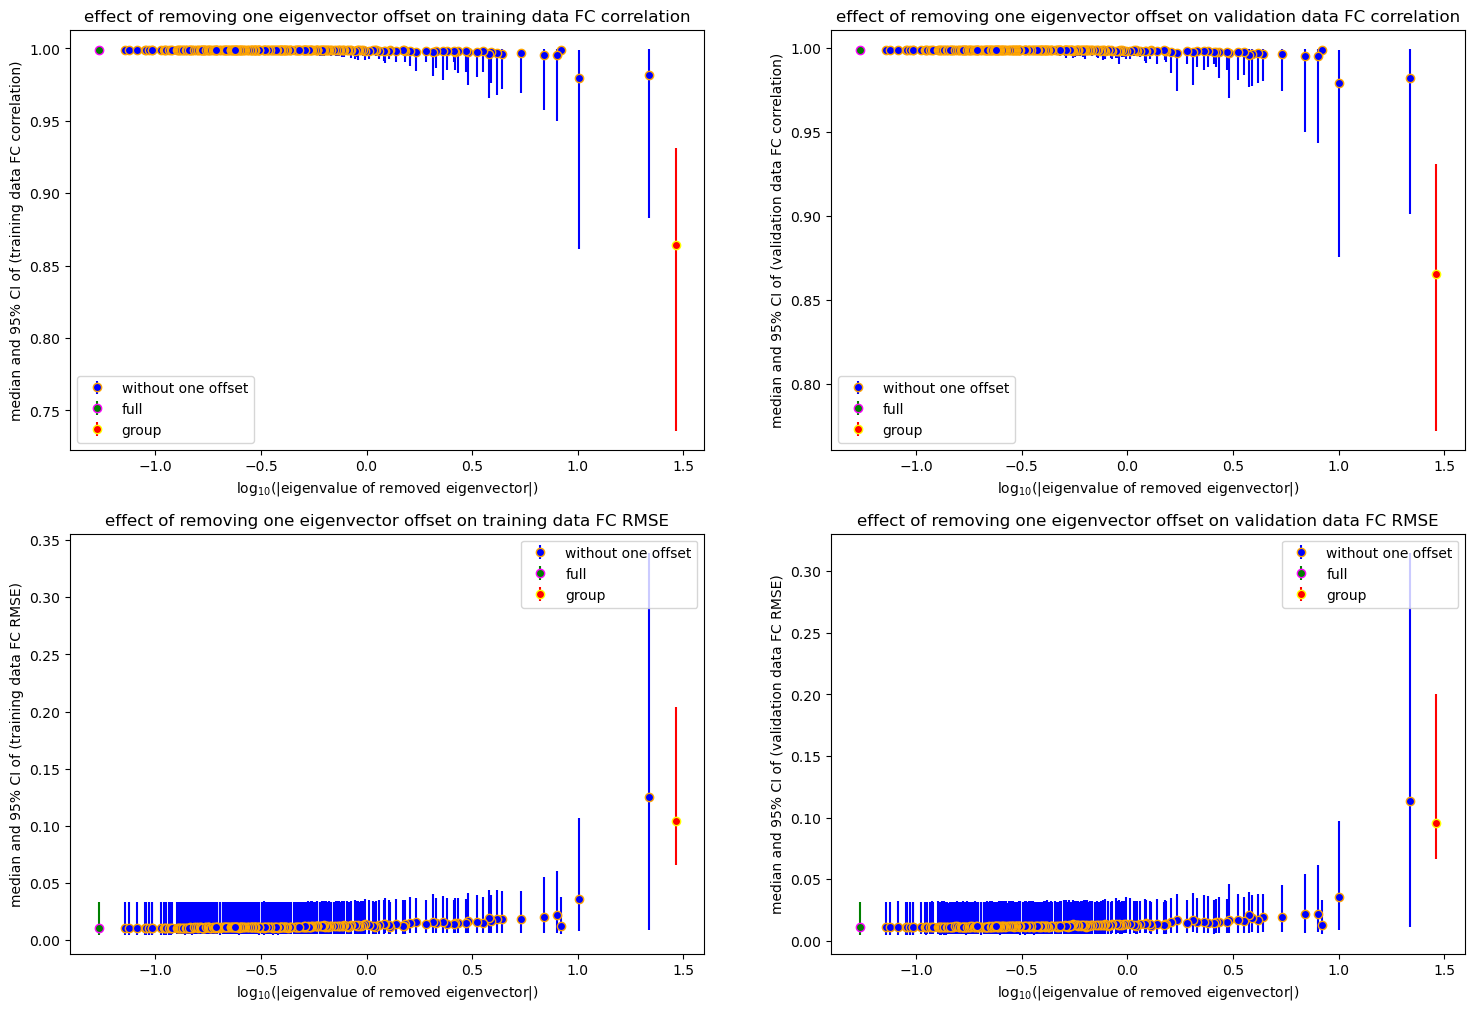

In [449]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(18, 12) )
plot_removal_effect(name='training data FC correlation', values_minus_offset=corr_minus_offset_training, values_group=corr_group_vs_individual_training, row=0, col=0)
plot_removal_effect(name='validation data FC correlation', values_minus_offset=corr_minus_offset_validation, values_group=corr_group_vs_individual_validation, row=0, col=1)
plot_removal_effect(name='training data FC RMSE', values_minus_offset=rmse_minus_offset_training, values_group=rmse_group_vs_individual_training, row=1, col=0)
plot_removal_effect(name='validation data FC RMSE', values_minus_offset=rmse_minus_offset_validation, values_group=rmse_group_vs_individual_validation, row=1, col=1)
plt.show()

In [115]:
print( corr_minus_offset_validation.size() )
print( log_L_ising.size() )

torch.Size([84, 100, 231])
torch.Size([231])


In [451]:
struct_to_offset_depth_small = 0
struct_to_offset_width_small = 2
struct_to_offset_batch_size_small = 10000
struct_to_offset_learning_rate_small = 0.01
struct_to_offset_string_small = f'struct_to_offset_{fim_param_string}_depth_{struct_to_offset_depth_small}_width_{struct_to_offset_width_small}_batch_{struct_to_offset_batch_size_small}_lr_{struct_to_offset_learning_rate_small}'

In [452]:
struct_to_offset_depth_big = 10
struct_to_offset_width_big = 1000
struct_to_offset_batch_size_big = 10000
struct_to_offset_learning_rate_big = 0.01
struct_to_offset_string_big = f'struct_to_offset_{fim_param_string}_depth_{struct_to_offset_depth_big}_width_{struct_to_offset_width_big}_batch_{struct_to_offset_batch_size_big}_lr_{struct_to_offset_learning_rate_big}'

In [453]:
median_abs_training_error_small = torch.load( os.path.join(stats_dir, f'median_abs_training_error_history_{struct_to_offset_string_small}.pt') )
print( 'median_abs_training_error_small size', median_abs_training_error_small.size() )
median_abs_validation_error_small = torch.load( os.path.join(stats_dir, f'median_abs_validation_error_history_{struct_to_offset_string_small}.pt') )
print( 'median_abs_validation_error_small size', median_abs_validation_error_small.size() )
median_abs_training_error_big = torch.load( os.path.join(stats_dir, f'median_abs_training_error_history_{struct_to_offset_string_big}.pt') )
print( 'median_abs_training_error_big size', median_abs_training_error_big.size() )
median_abs_validation_error_big = torch.load( os.path.join(stats_dir, f'median_abs_validation_error_history_{struct_to_offset_string_big}.pt') )
print( 'median_abs_validation_error_big size', median_abs_validation_error_big.size() )

median_abs_training_error_small size torch.Size([500, 231])
median_abs_validation_error_small size torch.Size([500, 231])
median_abs_training_error_big size torch.Size([500, 231])
median_abs_validation_error_big size torch.Size([500, 231])


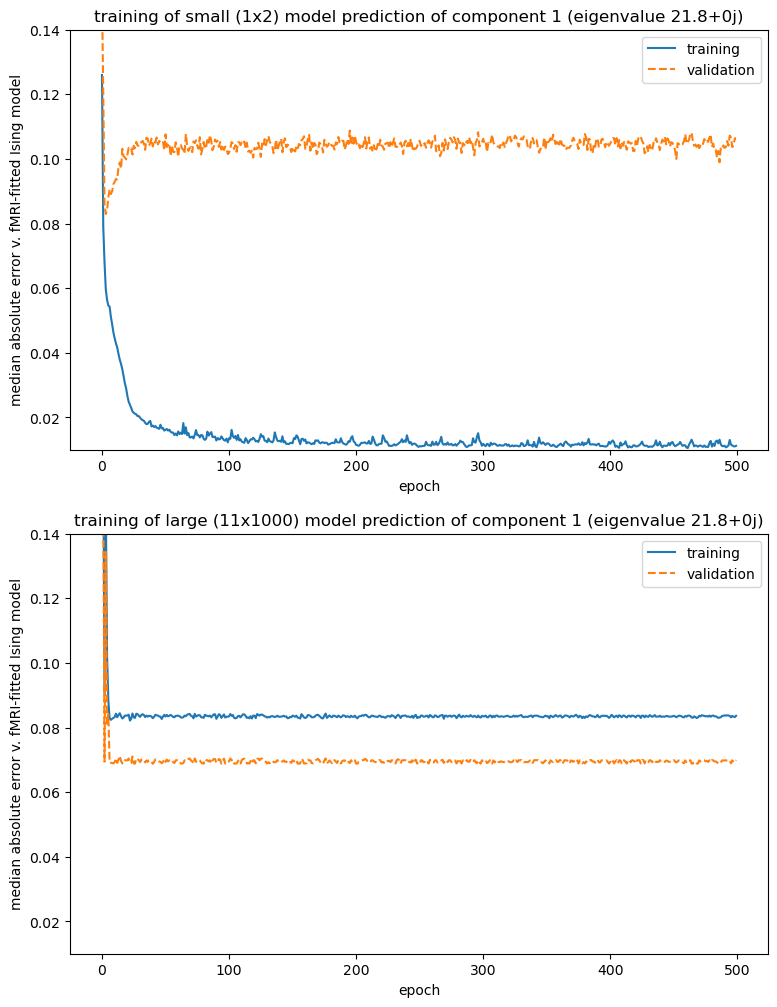

In [457]:
offset_index = 0
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 12))
axs[0].plot( median_abs_training_error_small[:,offset_index].detach().cpu().numpy(), linestyle='solid', label='training' )
axs[0].plot( median_abs_validation_error_small[:,offset_index].detach().cpu().numpy(), linestyle='dashed', label='validation' )
axs[0].set_ylim([0.01, 0.14])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('median absolute error v. fMRI-fitted Ising model')
axs[0].set_title(f'training of small (1x2) model prediction of component {offset_index+1} (eigenvalue {L_ising[offset_index]:.3g})')
axs[0].legend()
axs[1].plot( median_abs_training_error_big[:,offset_index].detach().cpu().numpy(), linestyle='solid', label='training' )
axs[1].plot( median_abs_validation_error_big[:,offset_index].detach().cpu().numpy(), linestyle='dashed', label='validation' )
axs[1].set_ylim([0.01, 0.14])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('median absolute error v. fMRI-fitted Ising model')
axs[1].set_title(f'training of large (11x1000) model prediction of component {offset_index+1} (eigenvalue {L_ising[offset_index]:.3g})')
axs[1].legend()

In [467]:
struct_to_offset_string = struct_to_offset_string_big

In [468]:
num_sim_steps_fc_test = 48000
fc_corr_struct_to_offset_training = torch.load( os.path.join(stats_dir, f'fc_corr_{struct_to_offset_string}_steps_{num_sim_steps_fc_test}_training.pt') )
print( 'fc_corr_struct_to_offset_training size', fc_corr_struct_to_offset_training.size() )
fc_corr_struct_to_offset_validation = torch.load( os.path.join(stats_dir, f'fc_corr_{struct_to_offset_string}_steps_{num_sim_steps_fc_test}_validation.pt') )
print( 'fc_corr_struct_to_offset_validation size', fc_corr_struct_to_offset_validation.size() )
fc_rmse_struct_to_offset_training = torch.load( os.path.join(stats_dir, f'fc_rmse_{struct_to_offset_string}_steps_{num_sim_steps_fc_test}_training.pt') )
print( 'fc_rmse_struct_to_offset_training size', fc_rmse_struct_to_offset_training.size() )
fc_rmse_struct_to_offset_validation = torch.load( os.path.join(stats_dir, f'fc_rmse_{struct_to_offset_string}_steps_{num_sim_steps_fc_test}_validation.pt') )
print( 'fc_rmse_struct_to_offset_validation size', fc_rmse_struct_to_offset_validation.size() )

fc_corr_struct_to_offset_training size torch.Size([669, 232])
fc_corr_struct_to_offset_validation size torch.Size([83, 232])
fc_rmse_struct_to_offset_training size torch.Size([669, 232])
fc_rmse_struct_to_offset_validation size torch.Size([83, 232])


In [ ]:
def plot_removal_effect_struct(name:str, values_minus_offset:torch.Tensor, values_group:torch.Tensor, row:int, col:int, margin:float=0.05):
    values_full = values_minus_offset[:,-1]
    values_minus_offset = values_minus_offset[:,:-1]
    num_subjects, _ = values_minus_offset.size()
    L_min = log_L_ising.min()
    L_max = log_L_ising.max()
    L_range = L_max - L_min
    full_pos = L_min - margin*L_range
    group_pos = L_max + margin*L_range
    log_L_ising_np = log_L_ising[None,:].repeat( (num_subjects,1) ).detach().cpu().numpy()
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs[row,col].scatter( torch.full_like(input=values_full, fill_value=full_pos).detach().cpu().numpy(), values_full.detach().cpu().numpy(), label='fully individualized' )
    axs[row,col].scatter( log_L_ising_np, values_minus_offset.detach().cpu().numpy(), label='without one offset' )
    axs[row,col].scatter( torch.full_like(input=values_group, fill_value=group_pos).detach().cpu().numpy(), values_group.detach().cpu().numpy(), label='group' )
    axs[row,col].set_xlabel('log$_{10}$(eigenvalue of removed egienvector)')
    axs[row,col].set_ylabel(name)
    axs[row,col].set_title(f'effect of removing the offset along an eigenvector on {name}')
    axs[row,col].legend()

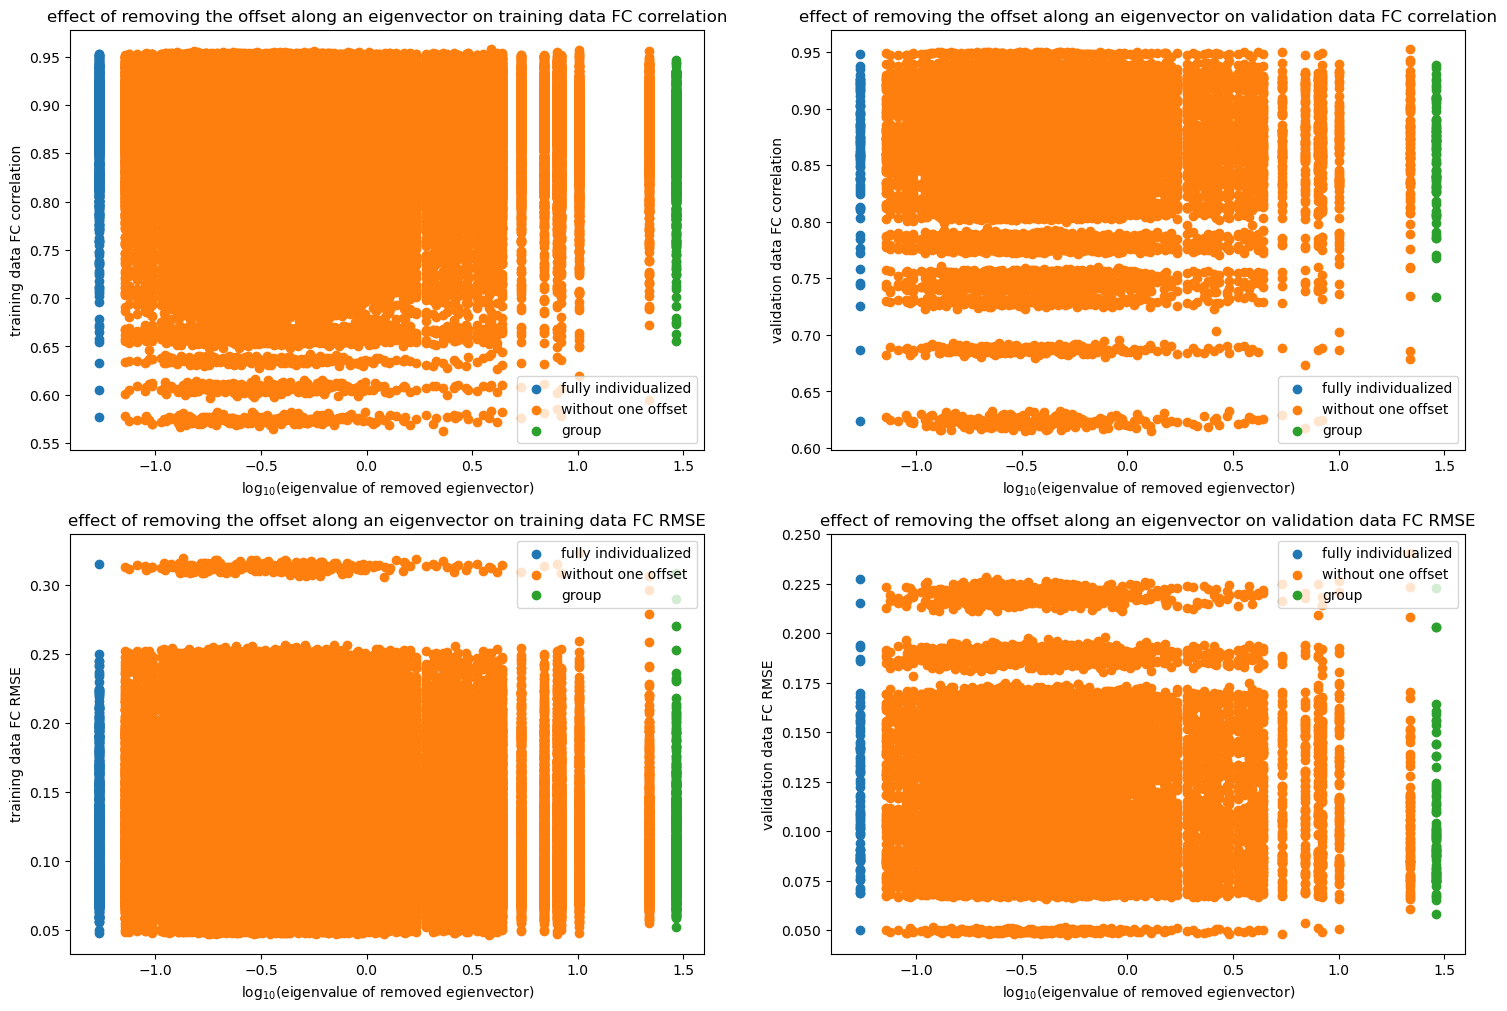

In [299]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
plot_removal_effect_struct(name='training data FC correlation', values_minus_offset=fc_corr_struct_to_offset_training, values_group=corr_group_vs_individual_training, row=0, col=0)
plot_removal_effect_struct(name='validation data FC correlation', values_minus_offset=fc_corr_struct_to_offset_validation, values_group=corr_group_vs_individual_validation, row=0, col=1)
plot_removal_effect_struct(name='training data FC RMSE', values_minus_offset=fc_rmse_struct_to_offset_training, values_group=rmse_group_vs_individual_training, row=1, col=0)
plot_removal_effect_struct(name='validation data FC RMSE', values_minus_offset=fc_rmse_struct_to_offset_validation, values_group=rmse_group_vs_individual_validation, row=1, col=1)
plt.show()

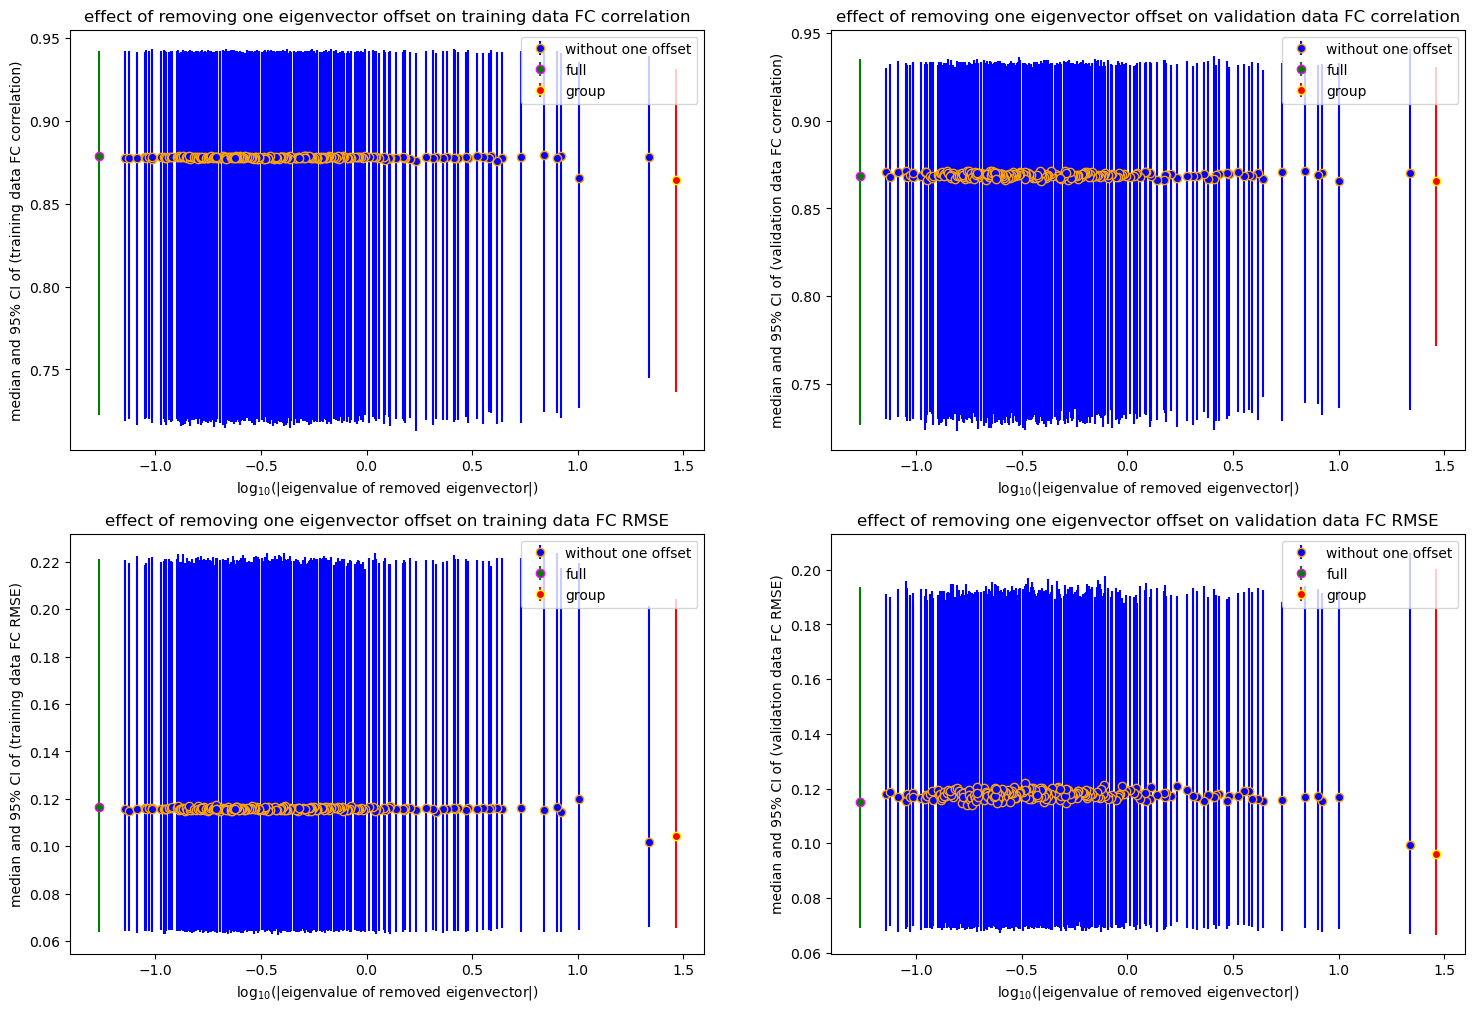

In [469]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
plot_removal_effect(name='training data FC correlation', values_minus_offset=fc_corr_struct_to_offset_training, values_group=corr_group_vs_individual_training, row=0, col=0)
plot_removal_effect(name='validation data FC correlation', values_minus_offset=fc_corr_struct_to_offset_validation, values_group=corr_group_vs_individual_validation, row=0, col=1)
plot_removal_effect(name='training data FC RMSE', values_minus_offset=fc_rmse_struct_to_offset_training, values_group=rmse_group_vs_individual_training, row=1, col=0)
plot_removal_effect(name='validation data FC RMSE', values_minus_offset=fc_rmse_struct_to_offset_validation, values_group=rmse_group_vs_individual_validation, row=1, col=1)
plt.show()

In [499]:
# group_struct_version = 'mean'
# group_struct_version = 'optim'
group_struct_version = 'weighted'
fim_struct = torch.load( os.path.join(stats_dir, f'fim_{group_struct_version}_{struct_to_offset_string}.pt') )
print( 'fim_struct size', fim_struct.size() )
V_struct = torch.load( os.path.join(stats_dir, f'V_{group_struct_version}_{struct_to_offset_string}.pt') )
print( 'V_struct size', V_struct.size() )
L_struct = torch.load( os.path.join(stats_dir, f'L_{group_struct_version}_{struct_to_offset_string}.pt') )
print( 'L_struct size', L_struct.size() )
projections_struct_training = torch.load( os.path.join(stats_dir, f'projections_{group_struct_version}_{struct_to_offset_string}_training.pt') )
print( 'projections_struct_training size', projections_struct_training.size() )
projections_struct_validation = torch.load( os.path.join(stats_dir, f'projections_{group_struct_version}_{struct_to_offset_string}_validation.pt') )
print( 'projections_struct_validation size', projections_struct_validation.size() )

fim_struct size torch.Size([294, 294])
V_struct size torch.Size([294, 294])
L_struct size torch.Size([294])
projections_struct_training size torch.Size([669, 294])
projections_struct_validation size torch.Size([83, 294])


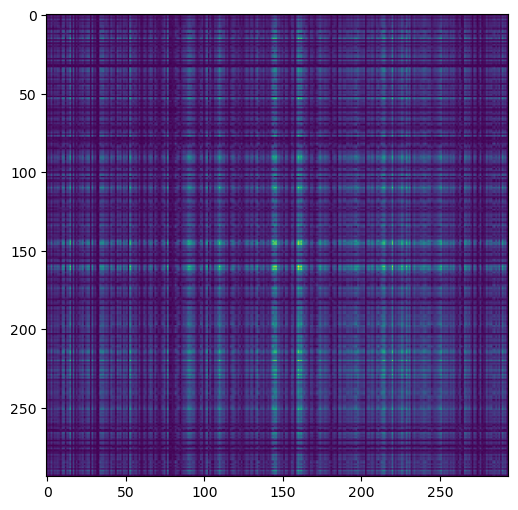

In [500]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
axs.imshow( fim_struct.abs().detach().cpu().numpy() )

In [346]:
def get_regions_and_sc(struct_values:torch.Tensor, num_nodes:int=num_nodes, features_per_region:int = hcp.features_per_area):
    dtype = struct_values.dtype
    device = struct_values.device
    num_values = struct_values.size(dim=-1)
    num_region_features = num_nodes*features_per_region
    regions = torch.index_select( input=struct_values, dim=-1, index=torch.arange(end=num_region_features, device=device) ).reshape( (num_nodes, features_per_region) )
    sc_flat_ut = torch.index_select( input=struct_values, dim=-1, index=torch.arange(start=num_region_features, end=num_values, device=device) )
    ut_indices = get_triu_logical_index(num_rows=num_nodes, num_cols=num_nodes).nonzero().flatten()
    sc_flat = torch.zeros( (num_nodes * num_nodes,), dtype=dtype, device=device )
    sc_flat.index_copy_(dim=-1, index=ut_indices, source=sc_flat_ut)
    sc = sc_flat.unflatten( dim=-1, sizes=(num_nodes, num_nodes) )
    sc_sym = sc + sc.transpose(dim0=-2, dim1=-1)
    return regions, sc_sym

In [347]:
def show_structural_feature_map(name:str, struct_values:torch.Tensor):
    regions, sc = get_regions_and_sc(struct_values=struct_values, num_nodes=num_nodes)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 32), gridspec_kw={'width_ratios':[1,6.5], 'height_ratios':[1], 'wspace':0.3})
    axs[0].imshow( regions.detach().cpu().numpy() )
    axs[0].set_xticks( range(hcp.features_per_area), labels=hcp.feature_names, rotation=90, fontsize=10 )
    axs[0].set_yticks( range(num_nodes), labels=selected_node_names, rotation=0, fontsize=10 )
    axs[0].set_title(f'region features')
    cmap_pos = axs[1].imshow( sc.detach().cpu().numpy() )
    axs[1].set_xticks( range(num_nodes), labels=selected_node_names, rotation=90, fontsize=10 )
    axs[1].set_yticks( range(num_nodes), labels=selected_node_names, rotation=0, fontsize=10 )
    axs[1].set_title(f'SC')
    fig.colorbar(cmap_pos, location = 'right', shrink = 0.7)
    fig.suptitle(name, x=0.45)
    fig.subplots_adjust(top=0.99, bottom=0.81)

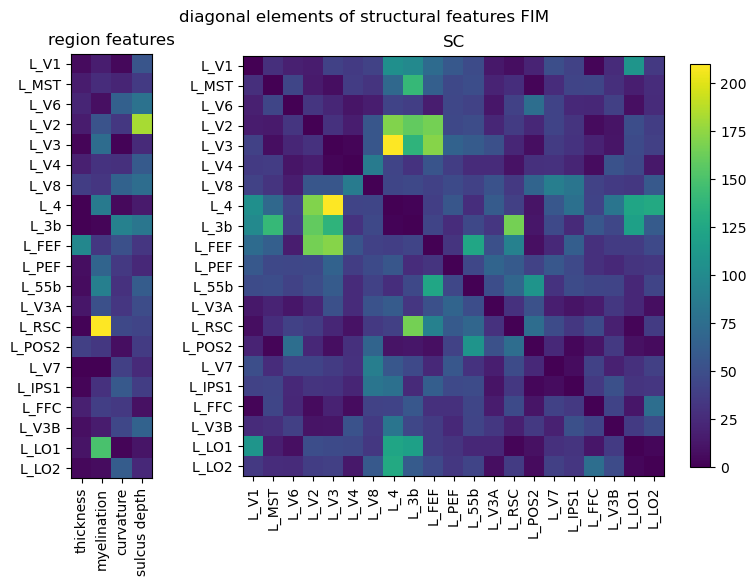

In [501]:
fim_struct_diag = torch.diag(fim_struct).abs()
fim_struct_name = 'diagonal elements of structural features FIM'
show_structural_feature_map(name=fim_struct_name, struct_values=fim_struct_diag)

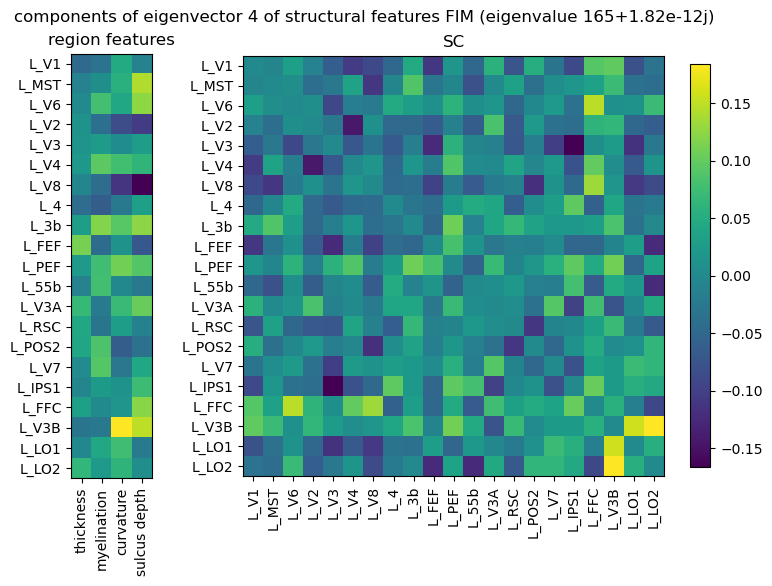

In [505]:
eig_index = 3
show_structural_feature_map(name=f'components of eigenvector {eig_index+1} of structural features FIM (eigenvalue {L_struct[eig_index]:.3g})', struct_values=V_struct[:,eig_index].real)

In [352]:
def show_structural_categories(name:str, struct_values:torch.Tensor):
    regions, sc = get_regions_and_sc(struct_values=struct_values, num_nodes=num_nodes)
    feature_list = regions.transpose(dim0=-2, dim1=-1).tolist()
    sc_list = sc.flatten(start_dim=-2, end_dim=-1).tolist()
    feature_list.append(sc_list)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.boxplot( feature_list )
    region_feature_name_list = ['thickness', 'myelination', 'curvature', 'sulcus depth']
    axs.set_xticklabels(region_feature_name_list+['SC'], rotation=0, fontsize=10)
    axs.set_xlabel('feature type')
    axs.set_ylabel(name)
    plt.show()
    for feature_index, feature_name in enumerate(region_feature_name_list):
        print_stats(name=f'{name} of type {feature_name}', values=regions[:,feature_index])
    print_stats(name=f'{name} of type SC', values=sc)

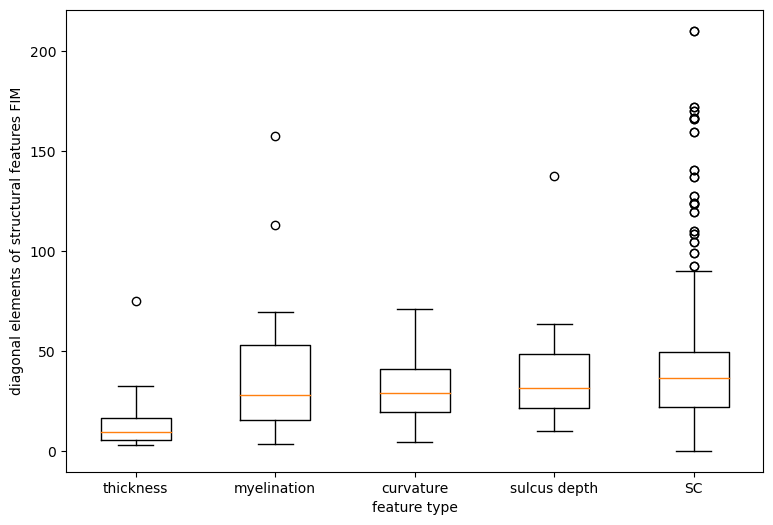

The distribution of diagonal elements of structural features FIM of type thickness values has median 9.13 with 95% CI [3.08, 53.4] and range [3.04, 74.7].
The distribution of diagonal elements of structural features FIM of type myelination values has median 28.1 with 95% CI [4.38, 135] and range [3.6, 157].
The distribution of diagonal elements of structural features FIM of type curvature values has median 28.7 with 95% CI [4.73, 61.1] and range [4.55, 70.9].
The distribution of diagonal elements of structural features FIM of type sulcus depth values has median 31.3 with 95% CI [10.9, 100] and range [9.87, 137].
The distribution of diagonal elements of structural features FIM of type SC values has median 36.4 with 95% CI [0, 159] and range [0, 210].


In [506]:
fim_struct_diag = torch.diag(fim_struct).abs()
fim_struct_name = 'diagonal elements of structural features FIM'
show_structural_categories(name=fim_struct_name, struct_values=fim_struct_diag)

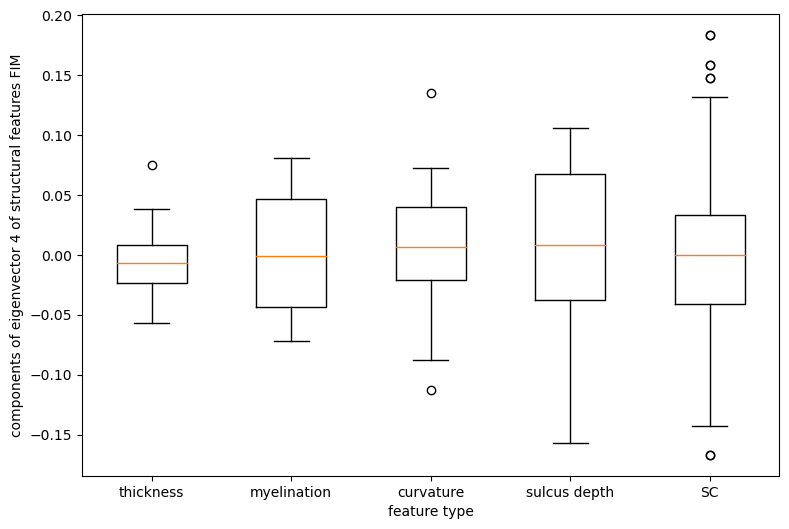

The distribution of components of eigenvector 4 of structural features FIM of type thickness values has median -0.00692 with 95% CI [-0.0547, 0.0569] and range [-0.0568, 0.0753].
The distribution of components of eigenvector 4 of structural features FIM of type myelination values has median -0.000601 with 95% CI [-0.0625, 0.0713] and range [-0.0716, 0.081].
The distribution of components of eigenvector 4 of structural features FIM of type curvature values has median 0.00658 with 95% CI [-0.1, 0.104] and range [-0.113, 0.135].
The distribution of components of eigenvector 4 of structural features FIM of type sulcus depth values has median 0.00804 with 95% CI [-0.131, 0.103] and range [-0.157, 0.106].
The distribution of components of eigenvector 4 of structural features FIM of type SC values has median 0 with 95% CI [-0.118, 0.107] and range [-0.167, 0.184].


In [510]:
eig_index = 3
show_structural_categories(name=f'components of eigenvector {eig_index+1} of structural features FIM', struct_values=V_struct[:,eig_index].real)

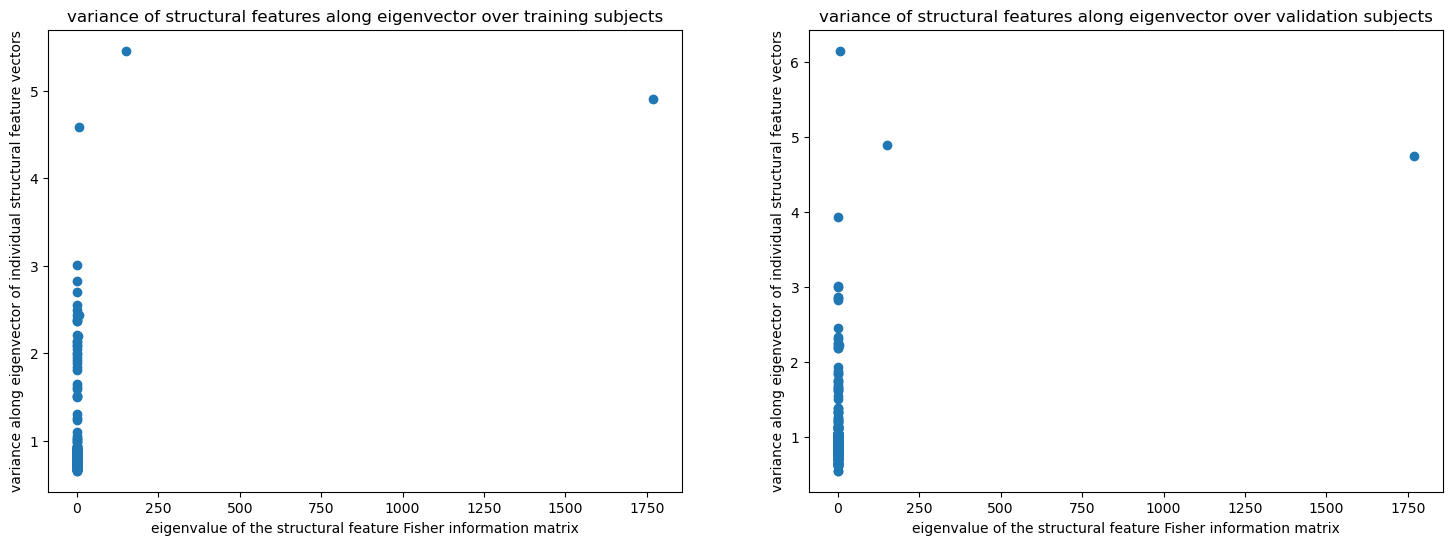

In [340]:
projections_struct_training_var = projections_struct_training.var(dim=0).abs()
projections_struct_validation_var = projections_struct_validation.var(dim=0).abs()
L_struct_np = L_struct.abs().detach().cpu().numpy()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[0].scatter( L_struct_np, projections_struct_training_var.detach().cpu().numpy() )
axs[0].set_xlabel('eigenvalue of the structural feature Fisher information matrix')
axs[0].set_ylabel('variance along eigenvector of individual structural feature vectors')
axs[0].set_title('variance of structural features along eigenvector over training subjects')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[1].scatter( L_struct_np, projections_struct_validation_var.detach().cpu().numpy() )
axs[1].set_xlabel('eigenvalue of the structural feature Fisher information matrix')
axs[1].set_ylabel('variance along eigenvector of individual structural feature vectors')
axs[1].set_title('variance of structural features along eigenvector over validation subjects')
plt.show()

(294,)
torch.Size([294])


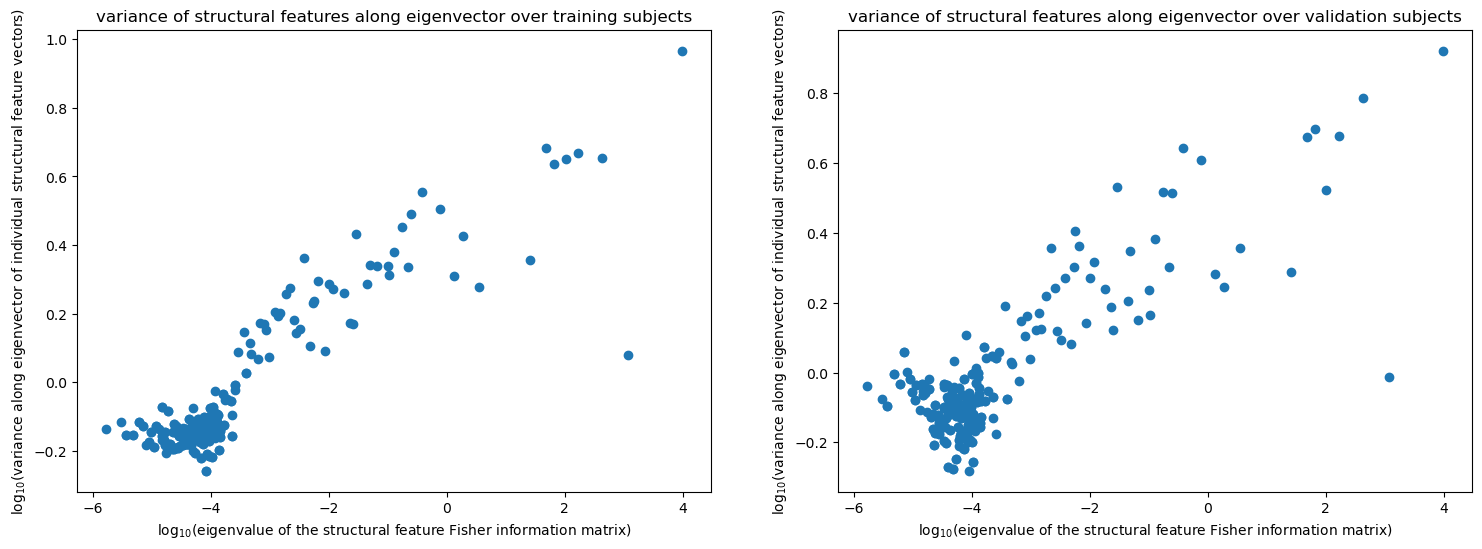

In [511]:
projections_struct_training_var = projections_struct_training.var(dim=0).abs()
log_projections_struct_training_var = torch.log10(projections_struct_training_var)
projections_struct_validation_var = projections_struct_validation.var(dim=0).abs()
log_projections_struct_validation_var = torch.log10(projections_struct_validation_var)
log_L_struct = torch.log10( L_struct.abs() )
log_L_struct_np = log_L_struct.detach().cpu().numpy()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
print( log_L_struct_np.shape )
print( projections_struct_training_var.size() )
axs[0].scatter( log_L_struct_np, log_projections_struct_training_var.detach().cpu().numpy() )
axs[0].set_xlabel('log$_{10}$(eigenvalue of the structural feature Fisher information matrix)')
axs[0].set_ylabel('log$_{10}$(variance along eigenvector of individual structural feature vectors)')
axs[0].set_title('variance of structural features along eigenvector over training subjects')
# axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
axs[1].scatter( log_L_struct_np, log_projections_struct_validation_var.detach().cpu().numpy() )
axs[1].set_xlabel('log$_{10}$(eigenvalue of the structural feature Fisher information matrix)')
axs[1].set_ylabel('log$_{10}$(variance along eigenvector of individual structural feature vectors)')
axs[1].set_title('variance of structural features along eigenvector over validation subjects')
plt.show()

In [512]:
L_struct_var_training_corr = torch.corrcoef(  torch.stack( (log_L_struct, log_projections_struct_training_var), dim=0 )  )[0,1].item()
print(f'correlation between eigenvalue and training data inter-subject structural feature variance along eigenvector in log-log scale: {L_struct_var_training_corr:.3g}')
L_struct_var_validation_corr = torch.corrcoef(  torch.stack( (log_L_struct, log_projections_struct_validation_var), dim=0 )  )[0,1].item()
print(f'correlation between eigenvalue and validation data inter-subject structural feature variance along eigenvector in log-log scale: {L_struct_var_validation_corr:.3g}')

correlation between eigenvalue and training data inter-subject structural feature variance along eigenvector in log-log scale: 0.903
correlation between eigenvalue and validation data inter-subject structural feature variance along eigenvector in log-log scale: 0.82


In [528]:
print( isnumeric(5) )

NameError: name 'isnumeric' is not defined